## Problem
The Home Credit Default Risk competition is a supervised classification machine learning task. The objective is to use historical financial and socioeconomic data to predict whether or not an applicant will be able to repay a loan. This is a standard supervised classification task.
## Dataset
The data is provided by [Home Credit](http://www.homecredit.net/about-us.aspx), a service dedicated to provided lines of credit (loans) to the unbanked population. 

There are 7 different data files:

* __application_train/application_test__: the main training and testing data with information about each loan application at Home Credit. Every loan has its own row and is identified by the `SK_ID_CURR`. The training application data comes with the `TARGET` with indicating 0: the loan was repaid and 1: the loan was not repaid. 
* __bureau__: data concerning client's previous credits from other financial institutions. Each previous credit has its own row in bureau and is identified by the `SK_ID_BUREAU`, Each loan in the application data can have multiple previous credits.
* __bureau_balance__: monthly data about the previous credits in bureau. Each row is one month of a previous credit, and a single previous credit can have multiple rows, one for each month of the credit length. 
* __previous_application__: previous applications for loans at Home Credit of clients who have loans in the application data. Each current loan in the application data can have multiple previous loans. Each previous application has one row and is identified by the feature `SK_ID_PREV`. 
* __POS_CASH_BALANCE__: monthly data about previous point of sale or cash loans clients have had with Home Credit. Each row is one month of a previous point of sale or cash loan, and a single previous loan can have many rows.
* __credit_card_balance__: monthly data about previous credit cards clients have had with Home Credit. Each row is one month of a credit card balance, and a single credit card can have many rows.
* __installments_payment__: payment history for previous loans at Home Credit. There is one row for every made payment and one row for every missed payment. 

The diagram below (provided by Home Credit) shows how the tables are related. This will be very useful when we need to define relationships in featuretools. 

![image](https://storage.googleapis.com/kaggle-media/competitions/home-credit/home_credit.png)

## Read in Data and Create Small Datasets



In [20]:
import pandas as pd
import numpy as np
import gc
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter("ignore", UserWarning)

import matplotlib.pylab as plt
%matplotlib inline
from matplotlib import rcParams
rcParams['figure.figsize'] = 8,4
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
import featuretools as ft

In [2]:
train = pd.read_csv('./all/application_train.csv')
test = pd.read_csv('./all/application_test.csv')
bu = pd.read_csv('./all/bureau.csv')
bu_blc = pd.read_csv('./all/bureau_balance.csv')
pr_app = pd.read_csv('./all/previous_application.csv')
pos_blc = pd.read_csv('./all/POS_CASH_balance.csv')
ins_pay = pd.read_csv('./all/installments_payments.csv')
cred_blc = pd.read_csv('./all/credit_card_balance.csv')

In [3]:
train.shape, test.shape

((307511, 122), (48744, 121))

In [4]:
train.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


In [5]:
test.head()

,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100001,Cash loans,F,N,Y,0,135000.0,568800.0,20560.5,450000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
1,100005,Cash loans,M,N,Y,0,99000.0,222768.0,17370.0,180000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
2,100013,Cash loans,M,Y,Y,0,202500.0,663264.0,69777.0,630000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,1.0,4.0
3,100028,Cash loans,F,N,Y,2,315000.0,1575000.0,49018.5,1575000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
4,100038,Cash loans,M,Y,N,1,180000.0,625500.0,32067.0,625500.0,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
# 6 additional files
bu.shape, bu_blc.shape, pr_app.shape, pos_blc.shape, ins_pay.shape, cred_blc.shape

((1716428, 17),
 (27299925, 3),
 (1670214, 37),
 (10001358, 8),
 (13605401, 8),
 (3840312, 23))

## Exploratory Data Analysis (EDA) of application data

### Examine the distribution of the target column

0    282686
1     24825
Name: TARGET, dtype: int64


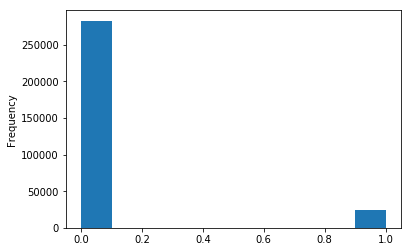

In [7]:
# Counts the category in train data. Herein 1 means default, while 0 means repaid on time.
print(train['TARGET'].value_counts())
train['TARGET'].plot.hist()

From above, we can see it is an imbalance class problem. Far more loans were repaid on time than not repaid.

### Column types

In [8]:
 # Distribution of datatypes
train.dtypes.value_counts()

float64    65
int64      41
object     16
dtype: int64

In [9]:
# Number of unique classes in each object column
train.select_dtypes("object").apply(pd.Series.nunique, axis = 0)

NAME_CONTRACT_TYPE             2
CODE_GENDER                    3
FLAG_OWN_CAR                   2
FLAG_OWN_REALTY                2
NAME_TYPE_SUITE                7
NAME_INCOME_TYPE               8
NAME_EDUCATION_TYPE            5
NAME_FAMILY_STATUS             6
NAME_HOUSING_TYPE              6
OCCUPATION_TYPE               18
WEEKDAY_APPR_PROCESS_START     7
ORGANIZATION_TYPE             58
FONDKAPREMONT_MODE             4
HOUSETYPE_MODE                 3
WALLSMATERIAL_MODE             7
EMERGENCYSTATE_MODE            2
dtype: int64

From above we know most of the categorical variables have a relatively small number of unique entries.

### Encoding categorical variables
Generally, 1) Label Encoding by assigning integer to each unique category, and 2) One-Hot Encoding by creating dummy variables for each unique category are widely used. The problem of label encoding for unbinary data is that it assigns arbitraty order for features, which is not what we want. So one-hot encoding is safer for the data that is not binary. However, the downside of the one-hot encoding is that the number of features will explode when the categorical variable has too many categories. To deal with it, we can perform one-hot encoding by PCA or other dimensionality reduction methods to reduce the number of dimensions.

In this project, we will use label encoding (LabelEncoder in Scikit-Learn) for any binary categorical variables, and one-hot encoding (pandas get_dummies) for others.

In [3]:
# Create a label encoding object
le = LabelEncoder()
le_count = 0

# Iterate through columns
for col in train:
    if train[col].dtype == 'object':
        # If 2 or fewer unique categories
        if len(list(train[col].unique())) <= 2:
            # Train on the training data
            le.fit(train[col])
            # Transform both training and testing data
            train[col] = le.transform(train[col])
            test[col] = le.transform(test[col])
            
            # Keep track of how many columns were label encoded
            le_count += 1
            
print('%d columns were label encoded.' % le_count)

3 columns were label encoded.


In [4]:
# One-hot encoding of categorical variables
train = pd.get_dummies(train)
test = pd.get_dummies(test)

print('Train data shape:',train.shape)
print('Test data shape:',test.shape)

Train data shape: (307511, 243)
Test data shape: (48744, 239)


### Aligning train and test data
Since the feature numbers are different between the train and test data due to the unseen categories in either of them. So we need to align the dataframs by removing the columns in the train data that not in the test data.

In [5]:
# Keep the target in the train data first
train_target = train['TARGET']

# Align the train and test data, keep only columns present in both dataframes
train, test = train.align(test, join = 'inner', axis = 1)

# Add the target back to the train
train['TARGET'] = train_target

print('Train data shape:', train.shape)
print('Test data shape:', test.shape)

Train data shape: (307511, 240)
Test data shape: (48744, 239)


### Properly Representing Variable Types
There are a number of columns in the dataframe that are represented as integers but are really discrete variables that can only take on a limited number of features. Some of these are Boolean flags (only 1 or 0) and two columns are ordinal (ordered discrete). Here we use *FeatureTool* to process it.

In [6]:
app_types = {}

# Iterate through the columns and record the Boolean columns
for col in train:
    # If column is a number with only two values, encode it as a Boolean
    if (train[col].dtype.name != ('category' or 'object')) and (len(train[col].unique()) <= 2):
        app_types[col] = ft.variable_types.Boolean

print('Number of boolean variables: ', len(app_types))

Number of boolean variables:  167


In [7]:
# Record ordinal variables
app_types['REGION_RATING_CLIENT'] = ft.variable_types.Ordinal
app_types['REGION_RATING_CLIENT_W_CITY'] = ft.variable_types.Ordinal

app_test_types = app_types.copy()
del app_test_types['TARGET']

### Time variables
#### Repalce outliers
One probelm we want to be on the lookout for when doing EDA is anomalies with in the data. These may be due to mistyped numbers, errors in measuing equipments, or they could be valid but extreme measurements, or outliers out of the acceptable range. Here we could use **describe** method to checkout the stats of a column.

In [15]:
# Since DAYS_BIRTH is negative due to the recording relative to the current loan application. We multiply -1
# and divide the number of days in a year.
(train['DAYS_BIRTH'] / -365).describe()

count    307511.000000
mean         43.936973
std          11.956133
min          20.517808
25%          34.008219
50%          43.150685
75%          53.923288
max          69.120548
Name: DAYS_BIRTH, dtype: float64

The ages look reasonable with no outliers out of either the low or high end.

count    307511.000000
mean        174.835742
std         387.056895
min         -49.073973
25%          -7.561644
50%          -3.323288
75%          -0.791781
max        1000.665753
Name: DAYS_EMPLOYED, dtype: float64


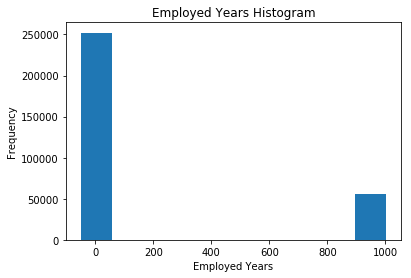

In [16]:
print((train['DAYS_EMPLOYED'] / 365).describe())
(train['DAYS_EMPLOYED']/365).plot.hist(title = 'Employed Years Histogram');
plt.xlabel('Employed Years');

The above for the employed years is unreasonable that the max value is around 1000 years!

In [8]:
anom = train[train['DAYS_EMPLOYED'] == train['DAYS_EMPLOYED'].max()]
non_anom = train[train['DAYS_EMPLOYED'] != train['DAYS_EMPLOYED'].max()]

print('Non-anomalies default on %0.2f%% of loans' % (100 * non_anom['TARGET'].mean()))
print('Anomalies default on %0.2f%% of loans' % (100 * anom['TARGET'].mean()))
print('There are %d anomalies with the same extreme value' % len(anom))

Non-anomalies default on 8.66% of loans
Anomalies default on 5.40% of loans
There are 55374 anomalies with the same extreme value


It turns out that the anomalies have a lower rate of default. The safest approach is to set the anomalies with a missing value and then have them filled in using imputation before machine learning. in this case, since all the anormalies have exactly the same maximum value, we need to fill them with the same value in case all of them share something in common. By the importance this characteristic, we will fill in the anomalous values with not a number (np.nan) and then create a new boolean column indicating whether or not the value was anomalous. 

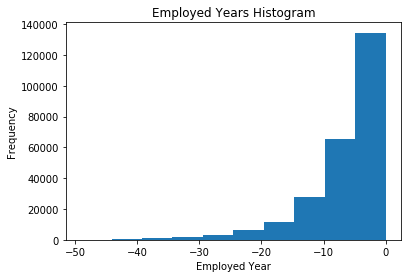

In [9]:
# Create an anomalous flag column
train['DAYS_EMPLOYED_ANOM'] = train['DAYS_EMPLOYED'] == train['DAYS_EMPLOYED'].max()

# Replace the anomalous values with nan
train['DAYS_EMPLOYED'].replace({train['DAYS_EMPLOYED'].max(): np.nan}, inplace = True)

(train['DAYS_EMPLOYED']/365).plot.hist(title = 'Employed Years Histogram');
plt.xlabel('Employed Year');

From the plot we can see the distribution looks to be in line with what we would expect.

In [10]:
# Same operation for the test data
test['DAYS_EMPLOYED_ANOM'] = test['DAYS_EMPLOYED'] == test['DAYS_EMPLOYED'].max()
test['DAYS_EMPLOYED'].replace({test['DAYS_EMPLOYED'].max(): np.nan}, inplace = True)

print('%d anomalies of test data out of %d entries' % (test["DAYS_EMPLOYED_ANOM"].sum(), len(test)))

9274 anomalies of test data out of 48744 entries


#### Replace outliers for Other Dataframes
There are a number of features with the extreme value of *365243* related to **DAYS**, also in other dataframes. Let's replace them with NAN.

In [11]:
train['DAYS_EMPLOYED'].max(),test['DAYS_EMPLOYED'].max()

(0.0, -1.0)

In [12]:
import re

def replace_day_outliers(df):
    """Replace 365243 with np.nan in any columns with DAYS"""
    for col in df.columns:
        if "DAYS" in col:
            df[col] = df[col].replace({365243: np.nan})

    return df

# Replace all the day outliers
train = replace_day_outliers(train)
test = replace_day_outliers(test)
bu = replace_day_outliers(bu)
bu_blc = replace_day_outliers(bu_blc)
cred_blc = replace_day_outliers(cred_blc)
pos_blc = replace_day_outliers(pos_blc)
pr_app = replace_day_outliers(pr_app)
ins_pay = replace_day_outliers(ins_pay)

#### **Time processing**
First we can establish an arbitrary date and then convert the time offset in months into a **Pandas timedelta** object.

#### ** Create LATE_PAYMENT Feature in Installments Payments**
The installments_payments data contains information on each payment made on the previous loans at Home Credit. It has two date offset columns:

* **DAYS_INSTALMENT**: number of days before current application at Home Credit that previous installment was supposed to be paid
* **DAYS_ENTRY_PAYMENT**: number of days before current application at Home Credit that previous installment was actually paid

By now the process should be familiar: convert to timedeltas and then make time columns. The **DAYS_INSTALMENT** will serve as the time_index.

In [22]:
# Create a feature showing late payment, positive means late payment
ins_pay['LATE_PAYMENT'] = ((pd.to_timedelta(ins_pay['DAYS_ENTRY_PAYMENT'], 'D') - pd.to_timedelta(ins_pay['DAYS_INSTALMENT'], 'D')).astype(int)
                           > 0).astype(int).astype('object')
ins_pay['LATE_PAYMENT'].head(10)

0    0
1    0
2    0
3    0
4    1
5    0
6    0
7    0
8    0
9    0
Name: LATE_PAYMENT, dtype: int64

### Correlations
Here we will check Pearson correlations between the features and target by using **corr** although the correlation coefficient is not the greatest method to represent "relevance" of a feature. It will give us an idea of possible relationships within the data.

In [23]:
# correlations = train.corr()['TARGET'].sort_values()

# # Display correlations
# print('Most Positive Correlations:\n', correlations.tail(15))
# print('\nMost Negative Correlations:\n', correlations.head(15))

Most Positive Correlations:
 OCCUPATION_TYPE_Laborers                             0.043019
FLAG_DOCUMENT_3                                      0.044346
REG_CITY_NOT_LIVE_CITY                               0.044395
FLAG_EMP_PHONE                                       0.045982
NAME_EDUCATION_TYPE_Secondary / secondary special    0.049824
REG_CITY_NOT_WORK_CITY                               0.050994
DAYS_ID_PUBLISH                                      0.051457
CODE_GENDER_M                                        0.054713
DAYS_LAST_PHONE_CHANGE                               0.055218
NAME_INCOME_TYPE_Working                             0.057481
REGION_RATING_CLIENT                                 0.058899
REGION_RATING_CLIENT_W_CITY                          0.060893
DAYS_EMPLOYED                                        0.074958
DAYS_BIRTH                                           0.078239
TARGET                                               1.000000
Name: TARGET, dtype: float64

Most Negati

It shows that the **DAYS_BIRTH** is the most positively correlated feature. But actually its value is negative, it means that elder people is less likely to default. For the convenience, we change it to absolute value.

Meanwhile, the 3 strongest negatively correlated features are **EXT_SOURCE_3**, **EXT_SOURCE_2** and **EXT_SOURCE_1**. According to the documentation, these three features represent a "normalized score from external data source".
### Effect of Age on Repayment

In [13]:
# Use absolute value for the DAYS_BIRTH feature
train['DAYS_BIRTH']=abs(train['DAYS_BIRTH'])
train['DAYS_BIRTH'].corr(train['TARGET'])

-0.07823930830982712

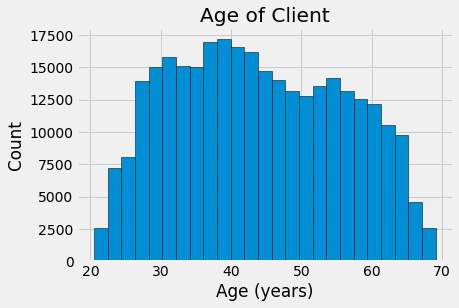

In [14]:
# Set the style of plots
plt.style.use('fivethirtyeight')

# Plot the distribution of ages in years
plt.hist(train['DAYS_BIRTH'] / 365, edgecolor = 'k', bins = 25)
plt.title('Age of Client'); plt.xlabel('Age (years)'); plt.ylabel('Count');

By itself, the distribution of age does not tell us much other than that there are no outliers as all the ages are reasonable. To visualize the effect of the age on the target, we will next make a kernel density estimation plot (KDE) colored by the value of the target. A kernel density estimate plot shows the distribution of a single variable and can be thought of as a smoothed histogram (it is created by computing a kernel, usually a Gaussian, at each data point and then averaging all the individual kernels to develop a single smooth curve). We will use the seaborn kdeplot for this graph.

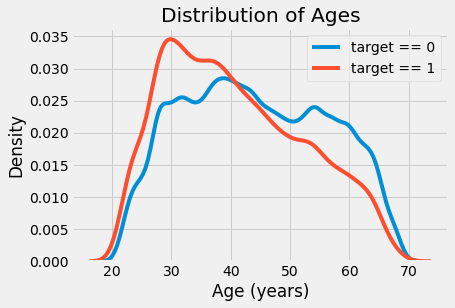

In [15]:
plt.figure(figsize = (6, 4))

# KDE plot of loans that were repaid on time
sns.kdeplot(train.loc[train['TARGET'] == 0, 'DAYS_BIRTH'] / 365, label = 'target == 0')

# KDE plot of loans which were not repaid on time
sns.kdeplot(train.loc[train['TARGET'] == 1, 'DAYS_BIRTH'] / 365, label = 'target == 1')

# Labeling of plot
plt.xlabel('Age (years)'); plt.ylabel('Density'); plt.title('Distribution of Ages');

The target == 1 curve skews towards the younger end of the range. Although this is not a significant correlation (-0.07 correlation coefficient), this variable is likely going to be useful in a machine learning model because it does affect the target. Let's look at this relationship in another way: average failure to repay loans by age bracket.

To make this graph, first we cut the age category into bins of 5 years each. Then, for each bin, we calculate the average value of the target, which tells us the ratio of loans that were not repaid in each age category.

In [16]:
# Age information into a separate dataframe
age_data = train[['TARGET', 'DAYS_BIRTH']]
age_data['YEARS_BIRTH'] = age_data['DAYS_BIRTH'] / 365

# Bin the age data
age_data['YEARS_BINNED'] = pd.cut(age_data['YEARS_BIRTH'], bins = np.linspace(20, 70, num = 11))
age_data.head(10)

,TARGET,DAYS_BIRTH,YEARS_BIRTH,YEARS_BINNED
0,1,9461,25.920548,"(25.0, 30.0]"
1,0,16765,45.931507,"(45.0, 50.0]"
2,0,19046,52.180822,"(50.0, 55.0]"
3,0,19005,52.068493,"(50.0, 55.0]"
4,0,19932,54.608219,"(50.0, 55.0]"
5,0,16941,46.413699,"(45.0, 50.0]"
6,0,13778,37.747945,"(35.0, 40.0]"
7,0,18850,51.643836,"(50.0, 55.0]"
8,0,20099,55.065753,"(55.0, 60.0]"
9,0,14469,39.641096,"(35.0, 40.0]"


In [17]:
# Group by the bin and calculate averages
age_groups  = age_data.groupby('YEARS_BINNED').mean()
age_groups

,TARGET,DAYS_BIRTH,YEARS_BIRTH
YEARS_BINNED,,,
"(20.0, 25.0]",0.123036,8532.795625,23.377522
"(25.0, 30.0]",0.111436,10155.219250,27.822518
"(30.0, 35.0]",0.102814,11854.848377,32.479037
"(35.0, 40.0]",0.089414,13707.908253,37.555913
"(40.0, 45.0]",0.078491,15497.661233,42.459346
"(45.0, 50.0]",0.074171,17323.900441,47.462741
"(50.0, 55.0]",0.066968,19196.494791,52.593136
"(55.0, 60.0]",0.055314,20984.262742,57.491131
"(60.0, 65.0]",0.052737,22780.547460,62.412459


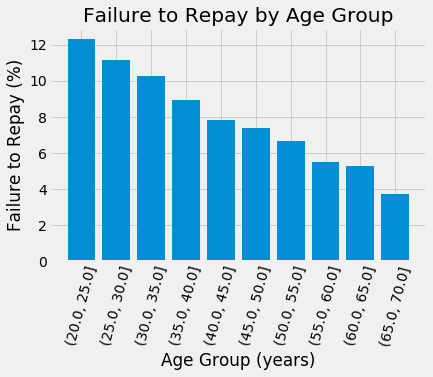

In [18]:
# Graph the age bins and the average of the target as a bar plot
plt.bar(age_groups.index.astype(str), 100 * age_groups['TARGET'])

# Plot labeling
plt.xticks(rotation = 75); plt.xlabel('Age Group (years)'); plt.ylabel('Failure to Repay (%)')
plt.title('Failure to Repay by Age Group');

It is clear that young applicants are more likely to fail repayment. The youngest three bins are more than 10% failure, while the oldest age group is below 5%.

### Exterior Sources (EXT_SOURCE)

In [19]:
# Extract the EXT_SOURCE variables and show correlations
ext_data = train[['TARGET', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH']]
ext_data_corrs = ext_data.corr()
ext_data_corrs

,TARGET,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,DAYS_BIRTH
TARGET,1.000000,-0.155317,-0.160472,-0.178919,-0.078239
EXT_SOURCE_1,-0.155317,1.000000,0.213982,0.186846,0.600610
EXT_SOURCE_2,-0.160472,0.213982,1.000000,0.109167,0.091996
EXT_SOURCE_3,-0.178919,0.186846,0.109167,1.000000,0.205478
DAYS_BIRTH,-0.078239,0.600610,0.091996,0.205478,1.000000


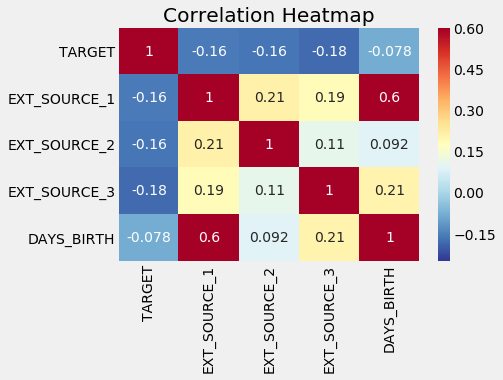

In [31]:
# Heatmap of correlations
sns.heatmap(ext_data_corrs, cmap = plt.cm.RdYlBu_r, vmin = -0.25, annot = True, vmax = 0.6)
plt.title('Correlation Heatmap');

All three **EXT_SOURCE** features have negative correlations with the target, indicating that as the value of the **EXT_SOURCE** increases, the client is more likely to repay the loan. We can also see that **DAYS_BIRTH** is positively correlated with **EXT_SOURCE_1** indicating that maybe one of the factors in this score is the client age.

Next we can look at the distribution of each of these features colored by the value of the target using *kdeplot*. This will let us visualize the effect of this variable on the target.

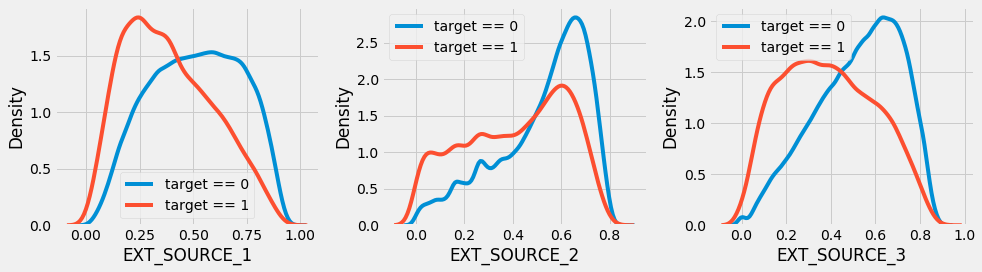

In [32]:
plt.figure(figsize = (14, 4))
# iterate through the sources
for i, source in enumerate(['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']):
    
    # create a new subplot for each source
    plt.subplot(1, 3, i + 1)
    # plot repaid loans
    sns.kdeplot(train.loc[train['TARGET'] == 0, source], label = 'target == 0')
    # plot loans that were not repaid
    sns.kdeplot(train.loc[train['TARGET'] == 1, source], label = 'target == 1')
    
    # Label the plots
    plt.xlabel('%s' % source); plt.ylabel('Density');
    
plt.tight_layout(h_pad = 2.5)

**EXT_SOURCE_3** displays the greatest difference between the values of the target. We can clearly see that this feature has some relationship to the likelihood of an applicant to repay a loan.

### Pairs Plot
As a final exploratory plot, we can make a pairs plot of the **EXT_SOURCE** variables and the **DAYS_BIRTH** variable. The Pairs Plot is a great exploration tool because it lets us see relationships between multiple pairs of variables as well as distributions of single variables. Here we are using the seaborn visualization library and the *PairGrid* function to create a Pairs Plot with scatterplots on the upper triangle, histograms on the diagonal, and 2D kernel density plots and correlation coefficients on the lower triangle.

In [ ]:
# Copy the data for plotting
plot_data = ext_data.drop(columns = ['DAYS_BIRTH']).copy()

# Add in the age of the client in years
plot_data['YEARS_BIRTH'] = age_data['YEARS_BIRTH']

# Drop na values and limit to first 100000 rows
plot_data = plot_data.dropna().loc[:100000, :]

# Function to calculate correlation coefficient between two columns
def corr_func(x, y, **kwargs):
    warnings.simplefilter("ignore", UserWarning)
    r = np.corrcoef(x, y)[0][1]
    ax = plt.gca()
    ax.annotate("r = {:.2f}".format(r),
                xy=(.2, .8), xycoords=ax.transAxes,
                size = 20)

# Create the pairgrid object
grid = sns.PairGrid(data = plot_data, size = 3, diag_sharey=False,
                    hue = 'TARGET', 
                    vars = [x for x in list(plot_data.columns) if x != 'TARGET'])

# Upper is a scatter plot
grid.map_upper(plt.scatter, alpha = 0.2)

# Diagonal is a histogram
grid.map_diag(sns.kdeplot)

# Bottom is density plot
grid.map_lower(sns.kdeplot, cmap = plt.cm.OrRd_r);

# plt.suptitle('Ext Source and Age Features Pairs Plot', size = 28, y = 1.05);

In this plot, the red indicates loans that were not repaid and the blue are loans that are paid. We can see the different relationships within the data. There does appear to be a moderate positive linear relationship between the **EXT_SOURCE_1** and the **DAYS_BIRTH** (or equivalently **YEARS_BIRTH**), indicating that this feature may take into account the age of the client.

## EDA of Bureau and Bureau_balance data
The two files are for financial data at other financial institutions.

In [33]:
bu.head()

,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY
0,215354,5714462,Closed,currency 1,-497,0,-153.0,-153.0,NaN,0,91323.0,0.0,NaN,0.0,Consumer credit,-131,NaN
1,215354,5714463,Active,currency 1,-208,0,1075.0,NaN,NaN,0,225000.0,171342.0,NaN,0.0,Credit card,-20,NaN
2,215354,5714464,Active,currency 1,-203,0,528.0,NaN,NaN,0,464323.5,NaN,NaN,0.0,Consumer credit,-16,NaN
3,215354,5714465,Active,currency 1,-203,0,NaN,NaN,NaN,0,90000.0,NaN,NaN,0.0,Credit card,-16,NaN
4,215354,5714466,Active,currency 1,-629,0,1197.0,NaN,77674.5,0,2700000.0,NaN,NaN,0.0,Consumer credit,-21,NaN


In [34]:
bu_blc.head()

,SK_ID_BUREAU,MONTHS_BALANCE,STATUS
0,5715448,0,C
1,5715448,-1,C
2,5715448,-2,C
3,5715448,-3,C
4,5715448,-4,C


#### Function to Convert Data Types
This will help reduce memory usage by using more efficient types for the variables. For example category is often a better type than object (unless the number of unique categories is close to the number of rows in the dataframe).

In [8]:
import sys

def return_size(df):
    """Return size of dataframe in gigabytes"""
    return round(sys.getsizeof(df) / 1e9, 2)

def convert_types(df, print_info = False):
    
    original_memory = df.memory_usage().sum()
    
    # Iterate through each column
    for c in df:
        
        # Convert ids and booleans to integers
        if ('SK_ID' in c):
            df[c] = df[c].fillna(0).astype(np.int32)
            
        # Convert objects to category
        elif (df[c].dtype == 'object') and (df[c].nunique() < df.shape[0]):
            df[c] = df[c].astype('category')
        
        # Booleans mapped to integers
        elif list(df[c].unique()) == [1, 0]:
            df[c] = df[c].astype(bool)
        
        # Float64 to float32
        elif df[c].dtype == float:
            df[c] = df[c].astype(np.float32)
            
        # Int64 to int32
        elif df[c].dtype == int:
            df[c] = df[c].astype(np.int32)
        
    new_memory = df.memory_usage().sum()
    
    if print_info:
        print(f'Original Memory Usage: {round(original_memory / 1e9, 2)} gb.')
        print(f'New Memory Usage: {round(new_memory / 1e9, 2)} gb.')
        
    return df

In [36]:
train = convert_types(train)
test = convert_types(test)

### Process Categorical Features

In [37]:
def label_encode(df):
    """
    Label encode categorical columns with binary features
    
    Args:
        df (dataframe)
        
    Returns:
        df after label encoding
    """
    le = LabelEncoder()
    le_count = 0

    # Iterate through columns
    for col in df:
        if df[col].dtype.name == 'category':
            # If 2 or fewer unique categories
            if len(list(df[col].unique())) <= 2:
                # Train on the training data
                le.fit(df[col])
                # Transform both training and testing data
                df[col] = le.transform(df[col])

                # Keep track of how many columns were label encoded
                le_count += 1

    print('%d columns were label encoded.' % le_count)
    return df

In [38]:
bu = convert_types(bu) 
bu = label_encode(bu)

0 columns were label encoded.


### Counts of a client's previous loans
* groupby: group a dataframe by a column. In this case we will group by the unique client, the SK_ID_CURR column
* agg: perform a calculation on the grouped data such as taking the mean of columns. We can either call the function directly (grouped_df.mean()) or use the agg function together with a list of transforms (grouped_df.agg([mean, max, min, sum]))
* merge: match the aggregated statistics to the appropriate client. We need to merge the original training data with the calculated stats on the SK_ID_CURR column which will insert NaN in any cell for which the client does not have the corresponding statistic

In [39]:
# Groupby the client id (SK_ID_CURR), count the number of previous loans, and rename the column
previous_loan_counts = bu.groupby('SK_ID_CURR', as_index=False)['SK_ID_BUREAU'].count().rename(columns = {'SK_ID_BUREAU': 'previous_loan_counts'})
previous_loan_counts.head()

,SK_ID_CURR,previous_loan_counts
0,100001,7
1,100002,8
2,100003,4
3,100004,2
4,100005,3


In [40]:
# Join to the training and testing dataframe
train = train.merge(previous_loan_counts, on = 'SK_ID_CURR', how = 'left')
test = test.merge(previous_loan_counts, on = 'SK_ID_CURR', how = 'left')

# Fill the missing values with 0 
train['previous_loan_counts'] = train['previous_loan_counts'].fillna(0)
test['previous_loan_counts'] = test['previous_loan_counts'].fillna(0)
train.head()

,SK_ID_CURR,NAME_CONTRACT_TYPE,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,...,WALLSMATERIAL_MODE_Monolithic,WALLSMATERIAL_MODE_Others,WALLSMATERIAL_MODE_Panel,"WALLSMATERIAL_MODE_Stone, brick",WALLSMATERIAL_MODE_Wooden,EMERGENCYSTATE_MODE_No,EMERGENCYSTATE_MODE_Yes,TARGET,DAYS_EMPLOYED_ANOM,previous_loan_counts
0,100002,0,0,True,0,202500.0,406597.5,24700.5,351000.0,0.018801,...,0,0,0,True,0,True,0,True,False,8.0
1,100003,0,0,False,0,270000.0,1293502.5,35698.5,1129500.0,0.003541,...,0,0,0,False,0,True,0,False,False,4.0
2,100004,1,1,True,0,67500.0,135000.0,6750.0,135000.0,0.010032,...,0,0,0,False,0,False,0,False,False,2.0
3,100006,0,0,True,0,135000.0,312682.5,29686.5,297000.0,0.008019,...,0,0,0,False,0,False,0,False,False,0.0
4,100007,0,0,True,0,121500.0,513000.0,21865.5,513000.0,0.028663,...,0,0,0,False,0,False,0,False,False,1.0


In [41]:
# Plots the disribution of a variable colored by value of the target
def kde_target(var_name, df):
    
    # Calculate the correlation coefficient between the new variable and the target
    corr = df['TARGET'].corr(df[var_name])
    
    # Calculate medians for repaid vs not repaid
    avg_repaid = df.ix[df['TARGET'] == 0, var_name].median()
    avg_not_repaid = df.ix[df['TARGET'] == 1, var_name].median()
    
    plt.figure(figsize = (8, 4))
    
    # Plot the distribution for target == 0 and target == 1
    sns.kdeplot(df.ix[df['TARGET'] == 0, var_name], label = 'TARGET == 0')
    sns.kdeplot(df.ix[df['TARGET'] == 1, var_name], label = 'TARGET == 1')
    
    # label the plot
    plt.xlabel(var_name); plt.ylabel('Density'); plt.title('%s Distribution' % var_name)
    plt.legend();
    
    # print out the correlation
    print('The correlation between %s and the TARGET is %0.4f' % (var_name, corr))
    # Print out average values
    print('Median value for loan that was not repaid = %0.4f' % avg_not_repaid)
    print('Median value for loan that was repaid =     %0.4f' % avg_repaid)

The correlation between previous_loan_counts and the TARGET is -0.0100
Median value for loan that was not repaid = 3.0000
Median value for loan that was repaid =     4.0000


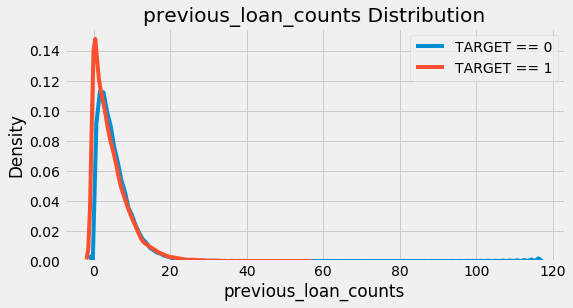

In [42]:
kde_target('previous_loan_counts', train)

From this it's difficult to tell if this variable will be important. The correlation coefficient is extremely weak and there is almost no noticeable difference in the distributions.

### Aggregating Numeric/Categorical Columns
Two core functions are defined for the aggregation of numeric and categorical columns. They can also be repeatedly used for column processing in other files.
* agg_numeric: calculate aggregation statistics (median, mean, max, min, std) for numeric variables.
* count_categorical: compute counts and normalized counts of each category in a categorical variable

In [9]:
def agg_numeric(df, parent_var, df_name):
    """
    Groups and aggregates the numeric values in a child dataframe
    by the parent variable.
    
    Parameters
    --------
        df (dataframe): 
            the child dataframe to calculate the statistics on
        parent_var (string): 
            the parent variable used for grouping and aggregating
        df_name (string): 
            the variable used to rename the columns
        
    Return
    --------
        agg (dataframe): 
            a dataframe with the statistics aggregated by the `parent_var` for 
            all numeric columns. Each observation of the parent variable will have 
            one row in the dataframe with the parent variable as the index. 
            The columns are also renamed using the `df_name`. Columns with all duplicate
            values are removed. 
    
    """
    
    # Remove id variables other than grouping variable
    for col in df:
        if col != parent_var and 'SK_ID' in col:
            df = df.drop(columns = col)
            
    # Only want the numeric variables
    parent_ids = df[parent_var].copy()
    numeric_df = df.select_dtypes('number').copy()
    numeric_df[parent_var] = parent_ids

    # Group by the specified variable and calculate the statistics
    agg = numeric_df.groupby(parent_var).agg(['median', 'mean', 'max', 'min', 'sum'])

    # Need to create new column names
    columns = []

    # Iterate through the variables names
    for var in agg.columns.levels[0]:
        if var != parent_var:
            # Iterate through the stat names
            for stat in agg.columns.levels[1]:
                # Make a new column name for the variable and stat
                columns.append('%s_%s_%s' % (df_name, var, stat))
    
    agg.columns = columns
    
    # Remove the columns with all redundant values
    _, idx = np.unique(agg, axis = 1, return_index=True)
    agg = agg.iloc[:, idx]
    
    return agg

#### Aggregated Stats of Bureau Dataframe

In [44]:
bu_agg_new = agg_numeric(bu.drop(columns = ['SK_ID_BUREAU']), 'SK_ID_CURR', 'bu')
bu_agg_new.head()

,bu_DAYS_CREDIT_sum,bu_DAYS_ENDDATE_FACT_sum,bu_DAYS_CREDIT_min,bu_DAYS_CREDIT_ENDDATE_min,bu_DAYS_ENDDATE_FACT_min,bu_DAYS_CREDIT_median,bu_DAYS_ENDDATE_FACT_mean,bu_DAYS_CREDIT_mean,bu_DAYS_ENDDATE_FACT_median,bu_DAYS_CREDIT_UPDATE_sum,...,bu_AMT_CREDIT_SUM_median,bu_AMT_CREDIT_SUM_mean,bu_AMT_CREDIT_SUM_DEBT_max,bu_AMT_CREDIT_SUM_max,bu_AMT_CREDIT_SUM_DEBT_sum,bu_AMT_CREDIT_SUM_sum,bu_AMT_CREDIT_MAX_OVERDUE_min,bu_AMT_CREDIT_MAX_OVERDUE_median,bu_AMT_CREDIT_MAX_OVERDUE_mean,bu_AMT_CREDIT_MAX_OVERDUE_max
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,
100001,-5145,-3302.0,-1572,-1329.0,-1328.0,-857.0,-825.500000,-735.000000,-715.0,-652,...,168345.000000,207623.578125,373239.0,378000.000000,596686.5,1.453365e+06,NaN,NaN,NaN,NaN
100002,-6992,-4185.0,-1437,-1072.0,-1185.0,-1042.5,-697.500000,-874.000000,-939.0,-3999,...,54130.500000,108131.945312,245781.0,450000.000000,245781.0,8.650556e+05,0.0,40.5,1681.029053,5043.64502
100003,-5603,-3292.0,-2586,-2434.0,-2131.0,-1205.5,-1097.333374,-1400.750000,-621.0,-3264,...,92576.250000,254350.125000,0.0,810000.000000,0.0,1.017400e+06,0.0,0.0,0.000000,0.00000
100004,-1734,-1065.0,-1326,-595.0,-683.0,-867.0,-532.500000,-867.000000,-532.5,-1064,...,94518.898438,94518.898438,0.0,94537.796875,0.0,1.890378e+05,0.0,0.0,0.000000,0.00000
100005,-572,-123.0,-373,-128.0,-123.0,-137.0,-123.000000,-190.666667,-123.0,-163,...,58500.000000,219042.000000,543087.0,568800.000000,568408.5,6.571260e+05,0.0,0.0,0.000000,0.00000


In [11]:
# Function to calculate correlations with the target for a dataframe
def target_corrs(df):

    # List of correlations
    corrs = []

    # Iterate through the columns 
    for col in df.columns:
        print(col)
        # Skip the target column
        if col != 'TARGET':
            # Calculate correlation with the target
            corr = df['TARGET'].corr(df[col])

            # Append the list as a tuple
            corrs.append((col, corr))
            
    # Sort by absolute magnitude of correlations
    corrs = sorted(corrs, key = lambda x: abs(x[1]), reverse = True)
    
    return corrs

In [10]:
def count_categorical(df, parent_var, df_name):
    """
    Aggregates the categorical features in a child dataframe
    for each observation of the parent variable.
    
    Parameters
    --------
    df : dataframe 
        The dataframe to calculate the value counts for.
        
    parent_var : string
        The variable by which to group and aggregate the dataframe. For each unique
        value of this variable, the final dataframe will have one row
        
    df_name : string
        Variable added to the front of column names to keep track of columns

    
    Return
    --------
    categorical : dataframe
        A dataframe with aggregated statistics for each observation of the parent_var
        The columns are also renamed and columns with duplicate values are removed.
        
    """
    
    # Select the categorical columns
    categorical = pd.get_dummies(df.select_dtypes('category'))

    # Make sure to put the identifying id on the column
    categorical[parent_var] = df[parent_var]

    # Groupby the group var and calculate the sum and mean
    categorical = categorical.groupby(parent_var).agg(['sum', 'count', 'mean'])
    
    column_names = []
    
    # Iterate through the columns in level 0
    for var in categorical.columns.levels[0]:
        # Iterate through the stats in level 1
        for stat in ['sum', 'count', 'mean']:
            # Make a new column name
            column_names.append('%s_%s_%s' % (df_name, var, stat))
    
    categorical.columns = column_names
    
    # Remove duplicate columns by values
    _, idx = np.unique(categorical, axis = 1, return_index = True)
    categorical = categorical.iloc[:, idx]
    
    return categorical

#### Counts of Bureau Dataframe

In [47]:
bu = convert_types(bu, print_info=True)

Original Memory Usage: 0.1 gb.
New Memory Usage: 0.1 gb.


In [48]:
bu_cat_counts = count_categorical(bu, 'SK_ID_CURR', 'bu')
bu_cat_counts.head()

,bu_CREDIT_TYPE_Mobile operator loan_mean,bu_CREDIT_TYPE_Mobile operator loan_sum,bu_CREDIT_TYPE_Loan for purchase of shares (margin lending)_mean,bu_CREDIT_TYPE_Loan for purchase of shares (margin lending)_sum,bu_CREDIT_ACTIVE_Bad debt_mean,bu_CREDIT_ACTIVE_Bad debt_sum,bu_CREDIT_TYPE_Interbank credit_mean,bu_CREDIT_TYPE_Interbank credit_sum,bu_CREDIT_TYPE_Real estate loan_mean,bu_CREDIT_TYPE_Real estate loan_sum,...,bu_CREDIT_TYPE_Credit card_sum,bu_CREDIT_ACTIVE_Active_mean,bu_CREDIT_ACTIVE_Closed_mean,bu_CREDIT_TYPE_Consumer credit_mean,bu_CREDIT_CURRENCY_currency 1_mean,bu_CREDIT_ACTIVE_Active_sum,bu_CREDIT_ACTIVE_Closed_sum,bu_CREDIT_TYPE_Consumer credit_sum,bu_CREDIT_CURRENCY_currency 1_sum,bu_CREDIT_ACTIVE_Active_count
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,
100001,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,...,0,0.428571,0.571429,1.000000,1.0,3,4,7,7,7
100002,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,...,4,0.250000,0.750000,0.500000,1.0,2,6,4,8,8
100003,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,...,2,0.250000,0.750000,0.500000,1.0,1,3,2,4,4
100004,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,...,0,0.000000,1.000000,1.000000,1.0,0,2,2,2,2
100005,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,...,1,0.666667,0.333333,0.666667,1.0,2,1,2,3,3


#### Value counts of Bureau Balance dataframe by loan

In [49]:
bu_blc = convert_types(bu_blc, print_info=True)
bu_blc = label_encode(bu_blc)
bu_blc.head()

Original Memory Usage: 0.66 gb.
New Memory Usage: 0.25 gb.
0 columns were label encoded.


,SK_ID_BUREAU,MONTHS_BALANCE,STATUS
0,5715448,0,C
1,5715448,-1,C
2,5715448,-2,C
3,5715448,-3,C
4,5715448,-4,C


In [50]:
# Categorical column processing
# Counts of each type of status for each previous loan
bu_blc_counts = count_categorical(bu_blc, 'SK_ID_BUREAU', 'bu_blc')
bu_blc_counts.head()

,bu_blc_STATUS_4_mean,bu_blc_STATUS_3_mean,bu_blc_STATUS_2_mean,bu_blc_STATUS_5_mean,bu_blc_STATUS_4_sum,bu_blc_STATUS_3_sum,bu_blc_STATUS_2_sum,bu_blc_STATUS_5_sum,bu_blc_STATUS_1_mean,bu_blc_STATUS_1_sum,bu_blc_STATUS_0_mean,bu_blc_STATUS_0_sum,bu_blc_STATUS_X_mean,bu_blc_STATUS_C_mean,bu_blc_STATUS_X_sum,bu_blc_STATUS_C_sum,bu_blc_STATUS_0_count
SK_ID_BUREAU,,,,,,,,,,,,,,,,,
5001709,0.0,0.0,0.0,0.0,0,0,0,0,0.0,0,0.000000,0,0.113402,0.886598,11,86,97
5001710,0.0,0.0,0.0,0.0,0,0,0,0,0.0,0,0.060241,5,0.361446,0.578313,30,48,83
5001711,0.0,0.0,0.0,0.0,0,0,0,0,0.0,0,0.750000,3,0.250000,0.000000,1,0,4
5001712,0.0,0.0,0.0,0.0,0,0,0,0,0.0,0,0.526316,10,0.000000,0.473684,0,9,19
5001713,0.0,0.0,0.0,0.0,0,0,0,0,0.0,0,0.000000,0,1.000000,0.000000,22,0,22


#### Aggregated stats of Bureau Balance dataframe by loan

In [51]:
# Numeric column processing
# Calculate value count statistics for each `SK_ID_CURR`, which is merged then
bu_blc_agg = agg_numeric(bu_blc, 'SK_ID_BUREAU', 'bu_blc')
bu_blc_agg.head()

,bu_blc_MONTHS_BALANCE_sum,bu_blc_MONTHS_BALANCE_min,bu_blc_MONTHS_BALANCE_median,bu_blc_MONTHS_BALANCE_max
SK_ID_BUREAU,,,,
5001709,-4656,-96,-48.0,0
5001710,-3403,-82,-41.0,0
5001711,-6,-3,-1.5,0
5001712,-171,-18,-9.0,0
5001713,-231,-21,-10.5,0


#### Aggregated Stats of Bureau Balance by Client

The above dataframes have the calculations done on each loan. Now we need to aggregate these for each client. We can do this by merging the dataframes together first and then since all the variables are numeric, we just need to aggregate the statistics again, this time grouping by the **SK_ID_CURR**.

In [52]:
# Dataframe grouped by the loan
bu_by_loan = bu_blc_agg.merge(bu_blc_counts, right_index = True, left_on = 'SK_ID_BUREAU', how = 'outer')

# Merge to include the SK_ID_CURR
bu_by_loan = bu_by_loan.merge(bu[['SK_ID_BUREAU', 'SK_ID_CURR']], on = 'SK_ID_BUREAU', how = 'left')

bu_by_loan.head()

,SK_ID_BUREAU,bu_blc_MONTHS_BALANCE_sum,bu_blc_MONTHS_BALANCE_min,bu_blc_MONTHS_BALANCE_median,bu_blc_MONTHS_BALANCE_max,bu_blc_STATUS_4_mean,bu_blc_STATUS_3_mean,bu_blc_STATUS_2_mean,bu_blc_STATUS_5_mean,bu_blc_STATUS_4_sum,...,bu_blc_STATUS_1_mean,bu_blc_STATUS_1_sum,bu_blc_STATUS_0_mean,bu_blc_STATUS_0_sum,bu_blc_STATUS_X_mean,bu_blc_STATUS_C_mean,bu_blc_STATUS_X_sum,bu_blc_STATUS_C_sum,bu_blc_STATUS_0_count,SK_ID_CURR
0,5001709,-4656,-96,-48.0,0,0.0,0.0,0.0,0.0,0,...,0.0,0,0.000000,0,0.113402,0.886598,11,86,97,NaN
1,5001710,-3403,-82,-41.0,0,0.0,0.0,0.0,0.0,0,...,0.0,0,0.060241,5,0.361446,0.578313,30,48,83,162368.0
2,5001711,-6,-3,-1.5,0,0.0,0.0,0.0,0.0,0,...,0.0,0,0.750000,3,0.250000,0.000000,1,0,4,162368.0
3,5001712,-171,-18,-9.0,0,0.0,0.0,0.0,0.0,0,...,0.0,0,0.526316,10,0.000000,0.473684,0,9,19,162368.0
4,5001713,-231,-21,-10.5,0,0.0,0.0,0.0,0.0,0,...,0.0,0,0.000000,0,1.000000,0.000000,22,0,22,150635.0


In [53]:
bu_blc_by_client = agg_numeric(bu_by_loan.drop(columns = ['SK_ID_BUREAU']), 'SK_ID_CURR', 'client')
bu_blc_by_client.head()

,client_bu_blc_MONTHS_BALANCE_sum_sum,client_bu_blc_MONTHS_BALANCE_sum_min,client_bu_blc_MONTHS_BALANCE_sum_median,client_bu_blc_MONTHS_BALANCE_sum_mean,client_bu_blc_MONTHS_BALANCE_min_sum,client_bu_blc_MONTHS_BALANCE_median_sum,client_bu_blc_MONTHS_BALANCE_min_min,client_bu_blc_MONTHS_BALANCE_min_median,client_bu_blc_MONTHS_BALANCE_median_min,client_bu_blc_MONTHS_BALANCE_min_mean,...,client_bu_blc_STATUS_C_sum_mean,client_bu_blc_STATUS_C_sum_median,client_bu_blc_STATUS_0_count_mean,client_bu_blc_STATUS_0_count_median,client_bu_blc_STATUS_X_sum_sum,client_bu_blc_STATUS_0_sum_sum,client_bu_blc_STATUS_C_sum_max,client_bu_blc_STATUS_0_count_max,client_bu_blc_STATUS_C_sum_sum,client_bu_blc_STATUS_0_count_sum
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,
100001.0,-2800,-1326,-406.0,-400.000000,-165,-82.5,-51,-28.0,-25.5,-23.571429,...,15.714286,18.0,24.571429,29.0,30.0,31.0,44,52,110.0,172
100002.0,-2701,-632,-424.0,-337.625000,-226,-175.0,-47,-34.0,-39.5,-28.250000,...,2.875000,2.0,13.750000,16.0,15.0,45.0,13,22,23.0,110
100005.0,-91,-78,-10.0,-30.333333,-18,-9.0,-12,-4.0,-6.0,-6.000000,...,1.666667,0.0,7.000000,5.0,2.0,14.0,5,13,5.0,21
100010.0,-3312,-2610,-1656.0,-1656.000000,-127,-92.0,-90,-63.5,-72.5,-63.500000,...,26.000000,26.0,36.000000,36.0,0.0,20.0,26,36,52.0,72
100013.0,-6756,-2346,-1815.0,-1689.000000,-226,-113.0,-68,-59.5,-34.0,-56.500000,...,25.750000,29.5,57.500000,60.5,41.0,79.0,44,69,103.0,230


### Insert Computed Features into Training/Testing Data

In [54]:
original_features = list(train.columns)
print('Original Number of Features: ', len(original_features))

Original Number of Features:  242


In [55]:
# Training merge
# Merge with the value counts of bureau
train = train.merge(bu_cat_counts, on = 'SK_ID_CURR', how = 'left')

# Merge with the stats of bureau
train = train.merge(bu_agg_new, on = 'SK_ID_CURR', how = 'left')

# Merge with the monthly information grouped by client
train = train.merge(bu_blc_by_client, on = 'SK_ID_CURR', how = 'left')
#--------------------------------------------------
# Testing merge
# Merge with the value counts of bureau
test = test.merge(bu_cat_counts, on = 'SK_ID_CURR', how = 'left')

# Merge with the stats of bureau
test = test.merge(bu_agg_new, on = 'SK_ID_CURR', how = 'left')

# Merge with the value counts of bureau balance
test = test.merge(bu_blc_by_client, on = 'SK_ID_CURR', how = 'left')

print('Shape of New Testing Data: ', train.shape)
print('Shape of New Testing Data: ', test.shape)

Shape of New Testing Data:  (307511, 454)
Shape of New Testing Data:  (48744, 453)


## EDA and Feature Processing of Four Additional Dataframes
The definitions of the four additional data files are:

* **previous_application** (called previous): previous applications for loans at Home Credit of clients who have loans in the application data. Each current loan in the application data can have multiple previous loans. Each previous application has one row and is identified by the feature SK_ID_PREV.
* **POS_CASH_BALANCE** (called cash): monthly data about previous point of sale or cash loans clients have had with Home Credit. Each row is one month of a previous point of sale or cash loan, and a single previous loan can have many rows.
* **credit_card_balance** (called credit): monthly data about previous credit cards clients have had with Home Credit. Each row is one month of a credit card balance, and a single credit card can have many rows.
* **installments_payment** (called installments): payment history for previous loans at Home Credit. There is one row for every made payment and one row for every missed payment.

Our general approach will be to apply the two core functions (*agg_numeric* and *agg_categorical*) to these dataframes, grouping by the client id, **SK_ID_CURR**. For the **POS_CASH_balance**, **credit_card_balance**, and **installment_payments**, we can first group by the **SK_ID_PREV**, the unique id for the previous loan. Then we will group the resulting dataframe by the **SK_ID_CURR** to calculate the aggregation statistics for each client across all of their previous loans.

Let's deal with one dataframe at a time. First up is the previous_applications. This has one row for every previous loan a client had at Home Credit. A client can have multiple previous loans which is why we need to aggregate statistics for each client.

#### previous_application

In [56]:
pr_app = convert_types(pr_app, print_info=True)
pr_app.head()

Original Memory Usage: 0.49 gb.
New Memory Usage: 0.16 gb.


,SK_ID_PREV,SK_ID_CURR,NAME_CONTRACT_TYPE,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,AMT_DOWN_PAYMENT,AMT_GOODS_PRICE,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,...,NAME_SELLER_INDUSTRY,CNT_PAYMENT,NAME_YIELD_GROUP,PRODUCT_COMBINATION,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL
0,2030495,271877,Consumer loans,1730.430054,17145.0,17145.0,0.0,17145.0,SATURDAY,15,...,Connectivity,12.0,middle,POS mobile with interest,NaN,-42.0,300.0,-42.0,-37.0,0.0
1,2802425,108129,Cash loans,25188.615234,607500.0,679671.0,NaN,607500.0,THURSDAY,11,...,XNA,36.0,low_action,Cash X-Sell: low,NaN,-134.0,916.0,NaN,NaN,1.0
2,2523466,122040,Cash loans,15060.735352,112500.0,136444.5,NaN,112500.0,TUESDAY,11,...,XNA,12.0,high,Cash X-Sell: high,NaN,-271.0,59.0,NaN,NaN,1.0
3,2819243,176158,Cash loans,47041.335938,450000.0,470790.0,NaN,450000.0,MONDAY,7,...,XNA,12.0,middle,Cash X-Sell: middle,NaN,-482.0,-152.0,-182.0,-177.0,1.0
4,1784265,202054,Cash loans,31924.394531,337500.0,404055.0,NaN,337500.0,THURSDAY,9,...,XNA,24.0,high,Cash Street: high,NaN,NaN,NaN,NaN,NaN,NaN


In [57]:
# Record boolean variables in the previous data
previous_types= {'NFLAG_LAST_APPL_IN_DAY': ft.variable_types.Boolean,
                 'NFLAG_INSURED_ON_APPROVAL': ft.variable_types.Boolean}

In [58]:
# Calculate aggregate statistics for each numeric column
previous_agg = agg_numeric(pr_app, 'SK_ID_CURR', 'prev')
print('Previous aggregation shape: ', previous_agg.shape)
previous_agg.head()

Previous aggregation shape:  (338857, 90)


,prev_DAYS_DECISION_sum,prev_DAYS_DECISION_min,prev_DAYS_DECISION_mean,prev_DAYS_DECISION_median,prev_DAYS_DECISION_max,prev_DAYS_FIRST_DUE_sum,prev_DAYS_FIRST_DUE_min,prev_DAYS_FIRST_DUE_mean,prev_DAYS_FIRST_DUE_median,prev_DAYS_FIRST_DUE_max,...,prev_DAYS_FIRST_DRAWING_median,prev_DAYS_FIRST_DRAWING_max,prev_RATE_INTEREST_PRIMARY_min,prev_RATE_INTEREST_PRIMARY_median,prev_RATE_INTEREST_PRIMARY_mean,prev_RATE_INTEREST_PRIMARY_max,prev_RATE_INTEREST_PRIVILEGED_min,prev_RATE_INTEREST_PRIVILEGED_median,prev_RATE_INTEREST_PRIVILEGED_mean,prev_RATE_INTEREST_PRIVILEGED_max
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,
100001,-1740,-1740,-1740.0,-1740.0,-1740,-1709.0,-1709.0,-1709.000000,-1709.0,-1709.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
100002,-606,-606,-606.0,-606.0,-606,-565.0,-565.0,-565.000000,-565.0,-565.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
100003,-3915,-2341,-1305.0,-828.0,-746,-3823.0,-2310.0,-1274.333374,-797.0,-716.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
100004,-815,-815,-815.0,-815.0,-815,-784.0,-784.0,-784.000000,-784.0,-784.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
100005,-1072,-757,-536.0,-536.0,-315,-706.0,-706.0,-706.000000,-706.0,-706.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [59]:
# Calculate value counts for each categorical column
previous_counts = count_categorical(pr_app, 'SK_ID_CURR', 'prev')
print('Previous counts shape: ', previous_counts.shape)
previous_counts.head()

Previous counts shape:  (338857, 285)


,prev_NAME_GOODS_CATEGORY_Animals_mean,prev_NAME_GOODS_CATEGORY_Animals_sum,prev_NAME_GOODS_CATEGORY_House Construction_mean,prev_NAME_GOODS_CATEGORY_House Construction_sum,prev_NAME_CASH_LOAN_PURPOSE_Refusal to name the goal_mean,prev_NAME_CASH_LOAN_PURPOSE_Refusal to name the goal_sum,prev_NAME_CASH_LOAN_PURPOSE_Money for a third person_mean,prev_NAME_CASH_LOAN_PURPOSE_Money for a third person_sum,prev_NAME_CASH_LOAN_PURPOSE_Hobby_mean,prev_NAME_CASH_LOAN_PURPOSE_Hobby_sum,...,prev_CODE_REJECT_REASON_XAP_mean,prev_FLAG_LAST_APPL_PER_CONTRACT_Y_mean,prev_NAME_PORTFOLIO_POS_sum,prev_NAME_CONTRACT_TYPE_Consumer loans_sum,prev_NAME_CASH_LOAN_PURPOSE_XAP_sum,prev_NAME_PRODUCT_TYPE_XNA_sum,prev_NAME_CONTRACT_STATUS_Approved_sum,prev_CODE_REJECT_REASON_XAP_sum,prev_FLAG_LAST_APPL_PER_CONTRACT_Y_sum,prev_NAME_CONTRACT_TYPE_Cash loans_count
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,
100001,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,...,1.0,1.0,1,1,1,1,1,1,1,1
100002,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,...,1.0,1.0,1,1,1,1,1,1,1,1
100003,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,...,1.0,1.0,2,2,2,2,3,3,3,3
100004,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,...,1.0,1.0,1,1,1,1,1,1,1,1
100005,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,...,1.0,1.0,1,1,1,2,1,2,2,2


We can join the calculated dataframe to the main training dataframe using a merge. Then we should delete the calculated dataframes to avoid using too much of the kernel memory.

In [60]:
# Merge in the previous information
train = train.merge(previous_counts, on ='SK_ID_CURR', how = 'left')
train = train.merge(previous_agg, on = 'SK_ID_CURR', how = 'left')

test = test.merge(previous_counts, on ='SK_ID_CURR', how = 'left')
test = test.merge(previous_agg, on = 'SK_ID_CURR', how = 'left')

# Remove variables to free memory
gc.enable()
del pr_app, previous_agg, previous_counts
gc.collect()

189

#### Function to Aggregate Stats at the Client Level

In [61]:
def aggregate_client(df, group_vars, df_names):
    """Aggregate a dataframe with data at the loan level 
    at the client level
    
    Args:
        df (dataframe): data at the loan level
        group_vars (list of two strings): grouping variables for the loan 
        and then the client (example ['SK_ID_PREV', 'SK_ID_CURR'])
        names (list of two strings): names to call the resulting columns
        (example ['cash', 'client'])
        
    Returns:
        df_client (dataframe): aggregated numeric stats at the client level. 
        Each client will have a single row with all the numeric data aggregated
    """
    
    # Aggregate the numeric columns
    df_agg = agg_numeric(df, parent_var = group_vars[0], df_name = df_names[0])
    
    # If there are categorical variables
    if any(df.dtypes == 'category'):
    
        # Count the categorical columns
        df_counts = count_categorical(df, parent_var = group_vars[0], df_name = df_names[0])

        # Merge the numeric and categorical
        df_by_loan = df_counts.merge(df_agg, on = group_vars[0], how = 'outer')

        gc.enable()
        del df_agg, df_counts
        gc.collect()

        # Merge to get the client id in dataframe
        df_by_loan = df_by_loan.merge(df[[group_vars[0], group_vars[1]]], on = group_vars[0], how = 'left')

        # Remove the loan id
        df_by_loan = df_by_loan.drop(columns = [group_vars[0]])

        # Aggregate numeric stats by column
        df_by_client = agg_numeric(df_by_loan, parent_var = group_vars[1], df_name = df_names[1])

        
    # No categorical variables
    else:
        # Merge to get the client id in dataframe
        df_by_loan = df_agg.merge(df[[group_vars[0], group_vars[1]]], on = group_vars[0], how = 'left')
        
        gc.enable()
        del df_agg
        gc.collect()
        
        # Remove the loan id
        df_by_loan = df_by_loan.drop(columns = [group_vars[0]])
        
        # Aggregate numeric stats by column
        df_by_client = agg_numeric(df_by_loan, parent_var = group_vars[1], df_name = df_names[1])
        
    # Memory management
    gc.enable()
    del df, df_by_loan
    gc.collect()

    return df_by_client

#### Monthly Cash Data

In [62]:
pos_blc = convert_types(pos_blc, print_info=True)
pos_blc.head()

Original Memory Usage: 0.64 gb.
New Memory Usage: 0.29 gb.


,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,CNT_INSTALMENT,CNT_INSTALMENT_FUTURE,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
0,1803195,182943,-31,48.0,45.0,Active,0,0
1,1715348,367990,-33,36.0,35.0,Active,0,0
2,1784872,397406,-32,12.0,9.0,Active,0,0
3,1903291,269225,-35,48.0,42.0,Active,0,0
4,2341044,334279,-35,36.0,35.0,Active,0,0


In [63]:
cash_by_client = aggregate_client(pos_blc, group_vars = ['SK_ID_PREV', 'SK_ID_CURR'], df_names = ['cash', 'client'])
cash_by_client.head()

,client_cash_MONTHS_BALANCE_sum_sum,client_cash_MONTHS_BALANCE_min_sum,client_cash_MONTHS_BALANCE_mean_sum,client_cash_MONTHS_BALANCE_median_sum,client_cash_MONTHS_BALANCE_max_sum,client_cash_MONTHS_BALANCE_sum_min,client_cash_MONTHS_BALANCE_sum_mean,client_cash_MONTHS_BALANCE_sum_median,client_cash_MONTHS_BALANCE_sum_max,client_cash_MONTHS_BALANCE_min_min,...,client_cash_SK_DPD_sum_sum,client_cash_CNT_INSTALMENT_FUTURE_max_sum,client_cash_NAME_CONTRACT_STATUS_Active_sum_sum,client_cash_CNT_INSTALMENT_min_sum,client_cash_CNT_INSTALMENT_mean_sum,client_cash_CNT_INSTALMENT_median_sum,client_cash_CNT_INSTALMENT_max_sum,client_cash_NAME_CONTRACT_STATUS_Active_count_sum,client_cash_CNT_INSTALMENT_FUTURE_sum_sum,client_cash_CNT_INSTALMENT_sum_sum
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,
100001,-2887,-669,-653.0,-653.0,-637,-378,-320.777778,-275.0,-275,-96,...,28,28.0,32.0,36.0,36.000000,36.0,36.0,41,62.0,164.0
100002,-3610,-361,-190.0,-190.0,-19,-190,-190.000000,-190.0,-190,-19,...,0,456.0,361.0,456.0,456.000000,456.0,456.0,361,5415.0,8664.0
100003,-13240,-1348,-1226.0,-1226.0,-1104,-858,-472.857143,-196.0,-172,-77,...,0,288.0,256.0,248.0,283.000000,288.0,288.0,272,1608.0,2840.0
100004,-408,-108,-102.0,-102.0,-96,-102,-102.000000,-102.0,-102,-27,...,0,16.0,12.0,12.0,15.000000,16.0,16.0,16,36.0,60.0
100005,-2420,-275,-220.0,-220.0,-165,-220,-220.000000,-220.0,-220,-25,...,0,132.0,99.0,99.0,128.699997,132.0,132.0,121,792.0,1287.0


In [64]:
print('Cash by Client Shape: ', cash_by_client.shape)
train = train.merge(cash_by_client, on = 'SK_ID_CURR', how = 'left')
test = test.merge(cash_by_client, on = 'SK_ID_CURR', how = 'left')

gc.enable()
del pos_blc, cash_by_client
gc.collect()

Cash by Client Shape:  (337252, 215)


21

#### Monthly Credit Data

In [65]:
cred_blc = convert_types(cred_blc, print_info = True)
cred_blc.head()

Original Memory Usage: 0.71 gb.
New Memory Usage: 0.34 gb.


,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,AMT_BALANCE,AMT_CREDIT_LIMIT_ACTUAL,AMT_DRAWINGS_ATM_CURRENT,AMT_DRAWINGS_CURRENT,AMT_DRAWINGS_OTHER_CURRENT,AMT_DRAWINGS_POS_CURRENT,AMT_INST_MIN_REGULARITY,...,AMT_RECIVABLE,AMT_TOTAL_RECEIVABLE,CNT_DRAWINGS_ATM_CURRENT,CNT_DRAWINGS_CURRENT,CNT_DRAWINGS_OTHER_CURRENT,CNT_DRAWINGS_POS_CURRENT,CNT_INSTALMENT_MATURE_CUM,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
0,2562384,378907,-6,56.970001,135000,0.0,877.5,0.0,877.5,1700.324951,...,0.000000,0.000000,0.0,1,0.0,1.0,35.0,Active,0,0
1,2582071,363914,-1,63975.554688,45000,2250.0,2250.0,0.0,0.0,2250.000000,...,64875.554688,64875.554688,1.0,1,0.0,0.0,69.0,Active,0,0
2,1740877,371185,-7,31815.224609,450000,0.0,0.0,0.0,0.0,2250.000000,...,31460.085938,31460.085938,0.0,0,0.0,0.0,30.0,Active,0,0
3,1389973,337855,-4,236572.109375,225000,2250.0,2250.0,0.0,0.0,11795.759766,...,233048.968750,233048.968750,1.0,1,0.0,0.0,10.0,Active,0,0
4,1891521,126868,-1,453919.468750,450000,0.0,11547.0,0.0,11547.0,22924.890625,...,453919.468750,453919.468750,0.0,1,0.0,1.0,101.0,Active,0,0


In [66]:
credit_by_client = aggregate_client(cred_blc, group_vars = ['SK_ID_PREV', 'SK_ID_CURR'], df_names = ['credit', 'client'])
credit_by_client.head()

,client_credit_MONTHS_BALANCE_sum_sum,client_credit_MONTHS_BALANCE_min_sum,client_credit_MONTHS_BALANCE_mean_sum,client_credit_MONTHS_BALANCE_median_sum,client_credit_MONTHS_BALANCE_sum_min,client_credit_MONTHS_BALANCE_sum_median,client_credit_MONTHS_BALANCE_sum_mean,client_credit_MONTHS_BALANCE_sum_max,client_credit_MONTHS_BALANCE_max_sum,client_credit_MONTHS_BALANCE_min_min,...,client_credit_AMT_PAYMENT_CURRENT_mean_mean,client_credit_AMT_PAYMENT_CURRENT_mean_max,client_credit_AMT_PAYMENT_CURRENT_max_min,client_credit_AMT_PAYMENT_CURRENT_max_mean,client_credit_AMT_PAYMENT_CURRENT_max_median,client_credit_AMT_PAYMENT_CURRENT_max_max,client_credit_AMT_DRAWINGS_ATM_CURRENT_max_min,client_credit_AMT_DRAWINGS_ATM_CURRENT_max_mean,client_credit_AMT_DRAWINGS_ATM_CURRENT_max_median,client_credit_AMT_DRAWINGS_ATM_CURRENT_max_max
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,
100006,-126,-36,-21.0,-21.0,-21,-21,-21.0,-21,-6,-6,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
100011,-210826,-5550,-2849.0,-2849.0,-2849,-2849,-2849.0,-2849,-148,-75,...,4843.063965,4843.063965,55485.0,55485.0,55485.0,55485.0,180000.0,180000.0,180000.0,180000.0
100013,-446976,-9216,-4656.0,-4656.0,-4656,-4656,-4656.0,-4656,-96,-96,...,7168.346191,7168.346191,153675.0,153675.0,153675.0,153675.0,157500.0,157500.0,157500.0,157500.0
100021,-2890,-306,-170.0,-170.0,-170,-170,-170.0,-170,-34,-18,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
100023,-480,-88,-60.0,-60.0,-60,-60,-60.0,-60,-32,-11,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [67]:
print('Credit by client shape: ', credit_by_client.shape)

train = train.merge(credit_by_client, on = 'SK_ID_CURR', how = 'left')
test = test.merge(credit_by_client, on = 'SK_ID_CURR', how = 'left')

gc.enable()
del cred_blc, credit_by_client
gc.collect()

Credit by client shape:  (103558, 545)


21

#### Installment Payments

In [68]:
ins_pay = convert_types(ins_pay, print_info = True)
ins_pay.head()

Original Memory Usage: 0.98 gb.
New Memory Usage: 0.49 gb.


,SK_ID_PREV,SK_ID_CURR,NUM_INSTALMENT_VERSION,NUM_INSTALMENT_NUMBER,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,AMT_INSTALMENT,AMT_PAYMENT,LATE_PAYMENT
0,1054186,161674,1.0,6,-1180.0,-1187.0,6948.359863,6948.359863,0
1,1330831,151639,0.0,34,-2156.0,-2156.0,1716.525024,1716.525024,0
2,2085231,193053,2.0,1,-63.0,-63.0,25425.000000,25425.000000,0
3,2452527,199697,1.0,3,-2418.0,-2426.0,24350.130859,24350.130859,0
4,2714724,167756,1.0,2,-1383.0,-1366.0,2165.040039,2160.584961,1


In [69]:
installments_by_client = aggregate_client(ins_pay, group_vars = ['SK_ID_PREV', 'SK_ID_CURR'], df_names = ['installments', 'client'])
installments_by_client.head()

,client_installments_DAYS_ENTRY_PAYMENT_sum_sum,client_installments_DAYS_INSTALMENT_sum_sum,client_installments_DAYS_ENTRY_PAYMENT_min_sum,client_installments_DAYS_INSTALMENT_min_sum,client_installments_DAYS_ENTRY_PAYMENT_median_sum,client_installments_DAYS_ENTRY_PAYMENT_mean_sum,client_installments_DAYS_INSTALMENT_mean_sum,client_installments_DAYS_INSTALMENT_median_sum,client_installments_DAYS_ENTRY_PAYMENT_max_sum,client_installments_DAYS_INSTALMENT_max_sum,...,client_installments_AMT_INSTALMENT_sum_median,client_installments_AMT_PAYMENT_sum_median,client_installments_AMT_PAYMENT_sum_max,client_installments_AMT_INSTALMENT_sum_max,client_installments_AMT_PAYMENT_mean_sum,client_installments_AMT_INSTALMENT_mean_sum,client_installments_AMT_INSTALMENT_max_sum,client_installments_AMT_PAYMENT_max_sum,client_installments_AMT_PAYMENT_sum_sum,client_installments_AMT_INSTALMENT_sum_sum
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,
100001,-52813.0,-52598.0,-15608.0,-15584.0,-15375.0,-15365.0,-15314.0,-15314.0,-15080.0,-15044.0,...,29250.900391,29250.900391,2.925090e+04,2.925090e+04,4.119593e+04,4.119593e+04,8.153775e+04,8.153775e+04,1.528387e+05,1.528387e+05
100002,-113867.0,-106495.0,-11153.0,-10735.0,-5928.0,-5993.0,-5605.0,-5605.0,-931.0,-475.0,...,219625.703125,219625.703125,2.196257e+05,2.196257e+05,2.196257e+05,2.196257e+05,1.008781e+06,1.008781e+06,4.172888e+06,4.172888e+06
100003,-367137.0,-365546.0,-37757.0,-37514.0,-34622.0,-34633.0,-34454.0,-34454.0,-31594.0,-31394.0,...,387113.937500,387113.937500,1.150977e+06,1.150977e+06,1.618865e+06,1.618865e+06,4.394102e+06,4.394102e+06,1.134881e+07,1.134881e+07
100004,-6855.0,-6786.0,-2385.0,-2352.0,-2289.0,-2285.0,-2262.0,-2262.0,-2181.0,-2172.0,...,21288.464844,21288.464844,2.128846e+04,2.128846e+04,2.128846e+04,2.128846e+04,3.172189e+04,3.172189e+04,6.386539e+04,6.386539e+04
100005,-49374.0,-47466.0,-6624.0,-6354.0,-5265.0,-5486.0,-5274.0,-5274.0,-4230.0,-4194.0,...,56161.843750,56161.843750,5.616184e+04,5.616184e+04,5.616184e+04,5.616184e+04,1.589062e+05,1.589062e+05,5.054566e+05,5.054566e+05


In [70]:
print('Installments by client shape: ', installments_by_client.shape)

train = train.merge(installments_by_client, on = 'SK_ID_CURR', how = 'left')
test = test.merge(installments_by_client, on = 'SK_ID_CURR', how = 'left')

gc.enable()
del ins_pay, installments_by_client
gc.collect()

Installments by client shape:  (339587, 175)


14

In [81]:
print('Training Shape: ', train.shape)
print('Testing Shape: ', test.shape)

Training Shape:  (307511, 1640)
Testing Shape:  (48744, 1639)


In [80]:
print(f'Training size: {return_size(train)}')
print(f'Testing size: {return_size(test)}')

Training size: 2.95
Testing size: 0.47


## Feature Selection
Now we have too many features to handle modeling and there are still more features to be added by feature engineeing later. So let's do feature selection first for all the features we have already. The actions are:

* Removed collinear features as measured by the correlation coefficient greater than 0.9
* Removed any columns with greater than 75% missing values in the train or test set
* Keep features with 95% cumulative feature importances in Light GBM

In the end of this section, the number of features is reduced from 1639 to 363.

### 1. Missing Values
An important consideration is the missing values in the dataframe. Columns with too many missing values might have to be dropped.

In [2]:
# Function to calculate missing values by column# Funct 
def missing_values_table(df, print_info = False):
        # Total missing values
        mis_val = df.isnull().sum()
        
        # Percentage of missing values
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        
        # Make a table with the results
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        
        # Rename the columns
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})
        
        # Sort the table by percentage of missing descending
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
        
        if print_info:
            # Print some summary information
            print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      
                "There are " + str(mis_val_table_ren_columns.shape[0]) +
                  " columns that have missing values.")
        
        # Return the dataframe with missing information
        return mis_val_table_ren_columns

In [3]:
def remove_missing_columns(train, test, threshold = 90):
    # Calculate missing stats for train and test (remember to calculate a percent!)
    train_miss = pd.DataFrame(train.isnull().sum())
    train_miss['percent'] = 100 * train_miss[0] / len(train)
    
    test_miss = pd.DataFrame(test.isnull().sum())
    test_miss['percent'] = 100 * test_miss[0] / len(test)
    
    # list of missing columns for train and test
    missing_train_columns = list(train_miss.index[train_miss['percent'] > threshold])
    missing_test_columns = list(test_miss.index[test_miss['percent'] > threshold])
    
    # Combine the two lists together
    missing_columns = list(set(missing_train_columns + missing_test_columns))
    
    # Print information
    print('There are %d columns with greater than %d%% missing values.' % (len(missing_columns), threshold))
    
    # Drop the missing columns and return
    train = train.drop(columns = missing_columns)
    test = test.drop(columns = missing_columns)
    
    return train, test

In [193]:
missing_train = missing_values_table(train)
missing_train.head(10)

,Missing Values,% of Total Values
bu_AMT_ANNUITY_max,227502,74.0
bu_AMT_ANNUITY_mean,227502,74.0
client_credit_AMT_DRAWINGS_CURRENT_sum_sum,220606,71.7
client_credit_AMT_DRAWINGS_CURRENT_mean_min,220606,71.7
client_credit_CNT_INSTALMENT_MATURE_CUM_mean_min,220606,71.7
client_credit_AMT_DRAWINGS_ATM_CURRENT_sum_min,220606,71.7
client_credit_AMT_DRAWINGS_POS_CURRENT_sum_min,220606,71.7
client_credit_CNT_DRAWINGS_ATM_CURRENT_sum_min,220606,71.7
client_credit_MONTHS_BALANCE_sum_sum,220606,71.7
client_credit_CNT_DRAWINGS_ATM_CURRENT_median_sum,220606,71.7


In [194]:
missing_test = missing_values_table(test)
missing_test.head(10)

,Missing Values,% of Total Values
COMMONAREA_AVG,33495,68.7
NONLIVINGAPARTMENTS_AVG,33347,68.4
FLOORSMIN_AVG,32466,66.6
OWN_CAR_AGE,32312,66.3
client_credit_AMT_DRAWINGS_POS_CURRENT_max_sum,32091,65.8
client_credit_CNT_DRAWINGS_ATM_CURRENT_sum_sum,32091,65.8
client_credit_AMT_PAYMENT_TOTAL_CURRENT_median_min,32091,65.8
client_credit_AMT_CREDIT_LIMIT_ACTUAL_min_min,32091,65.8
client_credit_AMT_PAYMENT_TOTAL_CURRENT_median_sum,32091,65.8
client_credit_AMT_CREDIT_LIMIT_ACTUAL_sum_sum,32091,65.8


In [201]:
# Define the threshold to filter missing percentage
threshold = 75

missing_train_vars = list(missing_train.index[missing_train['% of Total Values'] > threshold])
missing_test_vars = list(missing_test.index[missing_test['% of Total Values'] > threshold])
missing_columns = list(set(missing_test_vars + missing_train_vars))

print("Training data: %d columns > %d%% missing" % (len(missing_train_vars),threshold))
print("Testing data: %d columns > %d%% missing" % (len(missing_test_vars),threshold))
print("In total: %d columns > %d%% missing" % (len(missing_columns),threshold))

Training data: 0 columns > 75% missing
Testing data: 0 columns > 75% missing
In total: 0 columns > 75% missing


In [196]:
# Drop the missing columns
# train, test = remove_missing_columns(train, test)
train_removed = train.drop(columns = missing_columns)
test_removed = test.drop(columns = missing_columns)

In [197]:
print('Training Shape: ', train_removed.shape)
print('Testing Shape: ', test_removed.shape)

Training Shape:  (307511, 323)
Testing Shape:  (48744, 322)


### 2. Collinear Variables

Let's look for any variables that have a greather than a certain correlation with other variables.

In [82]:
# Calculate all correlations in dataframe
# corrs = train.corr()
# corrs.to_csv('corrs_1740.csv', index = False)

# Sort to see the correlation with TARGET if there is a need
# corrs = corrs.sort_values('TARGET', ascending = False)

# Read earlier calculated corr results due to its prohibitive time calculation.
corrs = pd.read_csv('corrs_1740.csv')

In [83]:
# Set the threshold
threshold = 0.90

# Empty dictionary to hold correlated variables
above_threshold_vars = {}

# For each column, record the variables that are above the threshold
for col in corrs:
    above_threshold_vars[col] = list(corrs.index[corrs[col] > threshold])

In [84]:
# Track columns to remove and columns already examined
cols_to_remove = []
cols_seen = []
cols_to_remove_pair = []

# Iterate through columns and correlated columns
for key, value in above_threshold_vars.items():
    # Keep track of columns already examined
    cols_seen.append(key)
    for x in value:
        if x == key:
            next
        else:
            # Only want to remove one in a pair
            if x not in cols_seen:
                cols_to_remove.append(x)
                cols_to_remove_pair.append(key)
            
cols_to_remove = list(set(cols_to_remove))
print('Number of columns to remove: ', len(cols_to_remove))

Number of columns to remove:  733


We can remove these columns from both the training and the testing datasets. We will have to compare performance after removing these variables with performance keeping these variables.

In [89]:
train = train.drop(columns = cols_to_remove)
test = test.drop(columns = cols_to_remove)

print('Training Corrs Removed Shape: ', train.shape)
print('Testing Corrs Removed Shape: ', test.shape)

Training Corrs Removed Shape:  (307511, 907)
Testing Corrs Removed Shape:  (48744, 906)


In [90]:
#train.to_csv('train_removed.csv', index = False)
#test.to_csv('test_removed.csv', index = False)

### 3. Model feature importance
Here we use the Light GBM to remove the features with 0 feature importance.

In [4]:
from xgboost.sklearn import XGBClassifier
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, Imputer
from sklearn.model_selection import KFold
import lightgbm as lgb

In [ ]:
def model(features, test_features, encoding = 'ohe', n_folds = 5):
    
    """Train and test a light gradient boosting model using
    cross validation. 
    
    Parameters
    --------
        features (pd.DataFrame): 
            dataframe of training features to use 
            for training a model. Must include the TARGET column.
        test_features (pd.DataFrame): 
            dataframe of testing features to use
            for making predictions with the model. 
        encoding (str, default = 'ohe'): 
            method for encoding categorical variables. Either 'ohe' for one-hot encoding or 'le' for integer label encoding
            n_folds (int, default = 5): number of folds to use for cross validation
        
    Return
    --------
        submission (pd.DataFrame): 
            dataframe with `SK_ID_CURR` and `TARGET` probabilities
            predicted by the model.
        feature_importances (pd.DataFrame): 
            dataframe with the feature importances from the model.
        valid_metrics (pd.DataFrame): 
            dataframe with training and validation metrics (ROC AUC) for each fold and overall.
        
    """
    
    # Extract the ids
    train_ids = features['SK_ID_CURR']
    test_ids = test_features['SK_ID_CURR']
    
    # Extract the labels for training
    labels = features['TARGET']
    
    # Remove the ids and target
    features = features.drop(columns = ['SK_ID_CURR', 'TARGET'])
    test_features = test_features.drop(columns = ['SK_ID_CURR'])
    
    
    # One Hot Encoding
    if encoding == 'ohe':
        features = pd.get_dummies(features)
        test_features = pd.get_dummies(test_features)
        
        # Align the dataframes by the columns
        features, test_features = features.align(test_features, join = 'inner', axis = 1)
        
        # No categorical indices to record
        cat_indices = 'auto'
    
    # Integer label encoding
    elif encoding == 'le':
        
        # Create a label encoder
        label_encoder = LabelEncoder()
        
        # List for storing categorical indices
        cat_indices = []
        
        # Iterate through each column
        for i, col in enumerate(features):
            if features[col].dtype == 'object':
                # Map the categorical features to integers
                features[col] = label_encoder.fit_transform(np.array(features[col].astype(str)).reshape((-1,)))
                test_features[col] = label_encoder.transform(np.array(test_features[col].astype(str)).reshape((-1,)))

                # Record the categorical indices
                cat_indices.append(i)
    
    # Catch error if label encoding scheme is not valid
    else:
        raise ValueError("Encoding must be either 'ohe' or 'le'")
        
    print('Training Data Shape: ', features.shape)
    print('Testing Data Shape: ', test_features.shape)
    
    # Extract feature names
    feature_names = list(features.columns)
    
    # Convert to np arrays
    features = np.array(features)
    test_features = np.array(test_features)
    
    # Create the kfold object
    k_fold = KFold(n_splits = n_folds, shuffle = False, random_state = 50)
    
    # Empty array for feature importances
    feature_importance_values = np.zeros(len(feature_names))
    
    # Empty array for test predictions
    test_predictions = np.zeros(test_features.shape[0])
    
    # Empty array for out of fold validation predictions
    out_of_fold = np.zeros(features.shape[0])
    
    # Lists for recording validation and training scores
    valid_scores = []
    train_scores = []
    
    # Iterate through each fold
    for train_indices, valid_indices in k_fold.split(features):
        
        # Training data for the fold
        train_features, train_labels = features[train_indices], labels[train_indices]
        # Validation data for the fold
        valid_features, valid_labels = features[valid_indices], labels[valid_indices]
        
        # Create the model
#         model = lgb.LGBMClassifier(n_estimators=10000, 
#                                    objective = 'binary', 
#                                    boosting_type='gbdt',
#                                    class_weight = 'balanced', 
#                                    learning_rate = 0.02, 
#                                    reg_alpha = 0.1, 
#                                    reg_lambda = 0.1,
#                                    n_jobs = -1, 
#                                    random_state = 50)
        model = lgb.LGBMClassifier(n_estimators=10000, 
                           objective = 'binary', 
                           boosting_type='gbdt',
                           class_weight = 'balanced', 
                           learning_rate = 0.02, 
                           colsample_bytree = 0.9497036,
                           subsample = 0.8715623,
                           subsample_freq = 1,
#                           max_depth = 8,
                           reg_alpha = 0.005, #0.041545473,
                           reg_lambda = 0.005, #0.0735294,
                           min_split_gain = 0.0222415,
                           min_child_weight = 60, # 39.3259775,
                           num_leaves = 20,
                           n_jobs = -1, 
                           random_state = 50)


        # Train the model
        model.fit(train_features, train_labels, eval_metric = 'auc',
                  eval_set = [(valid_features, valid_labels), (train_features, train_labels)],
                  eval_names = ['valid', 'train'], categorical_feature = cat_indices,
                  early_stopping_rounds = 200, verbose = 200)
        
        # Record the best iteration
        best_iteration = model.best_iteration_
        
        # Record the feature importances
        feature_importance_values += model.feature_importances_ / k_fold.n_splits
        
        # Make predictions
        test_predictions += model.predict_proba(test_features, num_iteration = best_iteration)[:, 1] / k_fold.n_splits
        
        # Record the out of fold predictions
        out_of_fold[valid_indices] = model.predict_proba(valid_features, num_iteration = best_iteration)[:, 1]
        
        # Record the best score
        valid_score = model.best_score_['valid']['auc']
        train_score = model.best_score_['train']['auc']
        
        valid_scores.append(valid_score)
        train_scores.append(train_score)
        
        # Clean up memory
        gc.enable()
        del model, train_features, valid_features
        gc.collect()
        
    # Make the submission dataframe
    submission = pd.DataFrame({'SK_ID_CURR': test_ids, 'TARGET': test_predictions})
    
    # Make the feature importance dataframe
    feature_importances = pd.DataFrame({'feature': feature_names, 'importance': feature_importance_values})
    
    # Overall validation score
    valid_auc = roc_auc_score(labels, out_of_fold)
    
    # Add the overall scores to the metrics
    valid_scores.append(valid_auc)
    train_scores.append(np.mean(train_scores))
    
    # Needed for creating dataframe of validation scores
    fold_names = list(range(n_folds))
    fold_names.append('overall')
    
    # Dataframe of validation scores
    metrics = pd.DataFrame({'fold': fold_names,
                            'train': train_scores,
                            'valid': valid_scores}) 
    
    return submission, feature_importances, metrics

In [21]:
def model1(features, test_features, encoding = 'ohe', n_folds = 5):
    
    """Train and test a light gradient boosting model using
    cross validation. 
    
    Parameters
    --------
        features (pd.DataFrame): 
            dataframe of training features to use 
            for training a model. Must include the TARGET column.
        test_features (pd.DataFrame): 
            dataframe of testing features to use
            for making predictions with the model. 
        encoding (str, default = 'ohe'): 
            method for encoding categorical variables. Either 'ohe' for one-hot encoding or 'le' for integer label encoding
            n_folds (int, default = 5): number of folds to use for cross validation
        
    Return
    --------
        submission (pd.DataFrame): 
            dataframe with `SK_ID_CURR` and `TARGET` probabilities
            predicted by the model.
        feature_importances (pd.DataFrame): 
            dataframe with the feature importances from the model.
        valid_metrics (pd.DataFrame): 
            dataframe with training and validation metrics (ROC AUC) for each fold and overall.
        
    """
    
    # Extract the ids
    train_ids = features['SK_ID_CURR']
    test_ids = test_features['SK_ID_CURR']
    
    # Extract the labels for training
    labels = features['TARGET']
    
    # Remove the ids and target
    features = features.drop(columns = ['SK_ID_CURR', 'TARGET'])
    test_features = test_features.drop(columns = ['SK_ID_CURR'])
    
    
    # One Hot Encoding
    if encoding == 'ohe':
        features = pd.get_dummies(features)
        test_features = pd.get_dummies(test_features)
        
        # Align the dataframes by the columns
        features, test_features = features.align(test_features, join = 'inner', axis = 1)
        
        # No categorical indices to record
        cat_indices = 'auto'
    
    # Integer label encoding
    elif encoding == 'le':
        
        # Create a label encoder
        label_encoder = LabelEncoder()
        
        # List for storing categorical indices
        cat_indices = []
        
        # Iterate through each column
        for i, col in enumerate(features):
            if features[col].dtype == 'object':
                # Map the categorical features to integers
                features[col] = label_encoder.fit_transform(np.array(features[col].astype(str)).reshape((-1,)))
                test_features[col] = label_encoder.transform(np.array(test_features[col].astype(str)).reshape((-1,)))

                # Record the categorical indices
                cat_indices.append(i)
    
    # Catch error if label encoding scheme is not valid
    else:
        raise ValueError("Encoding must be either 'ohe' or 'le'")
        
    print('Training Data Shape: ', features.shape)
    print('Testing Data Shape: ', test_features.shape)
    
    # Extract feature names
    feature_names = list(features.columns)
    
    # Convert to np arrays
    features = np.array(features)
    test_features = np.array(test_features)
    
    # Create the kfold object
    k_fold = KFold(n_splits = n_folds, shuffle = False, random_state = 50)
    
    # Empty array for feature importances
    feature_importance_values = np.zeros(len(feature_names))
    
    # Empty array for test predictions
    test_predictions = np.zeros(test_features.shape[0])
    
    # Empty array for out of fold validation predictions
    out_of_fold = np.zeros(features.shape[0])
    
    # Lists for recording validation and training scores
    valid_scores = []
    train_scores = []
    
    # Iterate through each fold
    for train_indices, valid_indices in k_fold.split(features):
        
        # Training data for the fold
        train_features, train_labels = features[train_indices], labels[train_indices]
        # Validation data for the fold
        valid_features, valid_labels = features[valid_indices], labels[valid_indices]
        
        # Create the model
#         model = lgb.LGBMClassifier(n_estimators=10000, 
#                                    objective = 'binary', 
#                                    boosting_type='gbdt',
#                                    class_weight = 'balanced', 
#                                    learning_rate = 0.02, 
#                                    reg_alpha = 0.1, 
#                                    reg_lambda = 0.1,
#                                    n_jobs = -1, 
#                                    random_state = 50)
        model = lgb.LGBMClassifier(n_estimators=10000, 
                           objective = 'binary', 
                           boosting_type='gbdt',
                           class_weight = 'balanced', 
                           learning_rate = 0.02, 
                           colsample_bytree = 0.9497036,
                           subsample = 0.8715623,
                           subsample_freq = 1,
                           max_depth = 6,
                           reg_alpha = 0.041545473,
                           reg_lambda = 0.0735294,
                           min_split_gain = 0.0222415,
                           min_child_weight = 60, # 39.3259775,
                           num_leaves = 20,
                           n_jobs = -1, 
                           random_state = 50)


        # Train the model
        model.fit(train_features, train_labels, eval_metric = 'auc',
                  eval_set = [(valid_features, valid_labels), (train_features, train_labels)],
                  eval_names = ['valid', 'train'], categorical_feature = cat_indices,
                  early_stopping_rounds = 200, verbose = 200)
        
        # Record the best iteration
        best_iteration = model.best_iteration_
        
        # Record the feature importances
        feature_importance_values += model.feature_importances_ / k_fold.n_splits
        
        # Make predictions
        test_predictions += model.predict_proba(test_features, num_iteration = best_iteration)[:, 1] / k_fold.n_splits
        
        # Record the out of fold predictions
        out_of_fold[valid_indices] = model.predict_proba(valid_features, num_iteration = best_iteration)[:, 1]
        
        # Record the best score
        valid_score = model.best_score_['valid']['auc']
        train_score = model.best_score_['train']['auc']
        
        valid_scores.append(valid_score)
        train_scores.append(train_score)
        
        # Clean up memory
        gc.enable()
        del model, train_features, valid_features
        gc.collect()
        
    # Make the submission dataframe
    submission = pd.DataFrame({'SK_ID_CURR': test_ids, 'TARGET': test_predictions})
    
    # Make the feature importance dataframe
    feature_importances = pd.DataFrame({'feature': feature_names, 'importance': feature_importance_values})
    
    # Overall validation score
    valid_auc = roc_auc_score(labels, out_of_fold)
    
    # Add the overall scores to the metrics
    valid_scores.append(valid_auc)
    train_scores.append(np.mean(train_scores))
    
    # Needed for creating dataframe of validation scores
    fold_names = list(range(n_folds))
    fold_names.append('overall')
    
    # Dataframe of validation scores
    metrics = pd.DataFrame({'fold': fold_names,
                            'train': train_scores,
                            'valid': valid_scores}) 
    
    return submission, feature_importances, metrics

In [6]:
def plot_feature_importances(df, threshold = 0.9):
    """
    Plots 15 most important features and the cumulative importance of features.
    Prints the number of features needed to reach threshold cumulative importance.
    
    Parameters
    --------
    df : dataframe
        Dataframe of feature importances. Columns must be feature and importance
    threshold : float, default = 0.9
        Threshold for prining information about cumulative importances
        
    Return
    --------
    df : dataframe
        Dataframe ordered by feature importances with a normalized column (sums to 1)
        and a cumulative importance column
    
    """
    
    plt.rcParams['font.size'] = 15
    
    # Sort features according to importance
    df = df.sort_values('importance', ascending = False).reset_index()
    
    # Normalize the feature importances to add up to one
    df['importance_normalized'] = df['importance'] / df['importance'].sum()
    df['cumulative_importance'] = np.cumsum(df['importance_normalized'])

    # Make a horizontal bar chart of feature importances
    plt.figure(figsize = (8, 6))
    ax = plt.subplot()
    
    # Need to reverse the index to plot most important on top
    ax.barh(list(reversed(list(df.index[:15]))), 
            df['importance_normalized'].head(15), 
            align = 'center', edgecolor = 'k')
    
    # Set the yticks and labels
    ax.set_yticks(list(reversed(list(df.index[:15]))))
    ax.set_yticklabels(df['feature'].head(15))
    
    # Plot labeling
    plt.xlabel('Normalized Importance'); plt.title('Feature Importances')
    plt.show()
    
    # Cumulative importance plot
    plt.figure(figsize = (6, 4))
    plt.plot(list(range(len(df))), df['cumulative_importance'], 'r-')
    plt.xlabel('Number of Features'); plt.ylabel('Cumulative Importance'); 
    plt.title('Cumulative Feature Importance');
    plt.show();
    
    importance_index = np.min(np.where(df['cumulative_importance'] > threshold))
    print('%d features required for %0.2f of cumulative importance' % (importance_index + 1, threshold))
    
    return df

In [95]:
submission, fi, metrics = model(train, test)
print('Baseline metrics')
print(metrics)

Training Data Shape:  (307511, 905)
Testing Data Shape:  (48744, 905)
Training until validation scores don't improve for 100 rounds.
[200]	valid's auc: 0.782309	train's auc: 0.830109
[400]	valid's auc: 0.783036	train's auc: 0.86802
Early stopping, best iteration is:
[332]	valid's auc: 0.783476	train's auc: 0.856238
Training until validation scores don't improve for 100 rounds.
[200]	valid's auc: 0.78599	train's auc: 0.829899
[400]	valid's auc: 0.787988	train's auc: 0.867913
[600]	valid's auc: 0.787738	train's auc: 0.896434
Early stopping, best iteration is:
[532]	valid's auc: 0.788367	train's auc: 0.887519
Training until validation scores don't improve for 100 rounds.
[200]	valid's auc: 0.778183	train's auc: 0.831216
[400]	valid's auc: 0.780852	train's auc: 0.868278
Early stopping, best iteration is:
[370]	valid's auc: 0.780978	train's auc: 0.863514
Training until validation scores don't improve for 100 rounds.
[200]	valid's auc: 0.784345	train's auc: 0.829831
[400]	valid's auc: 0.7864

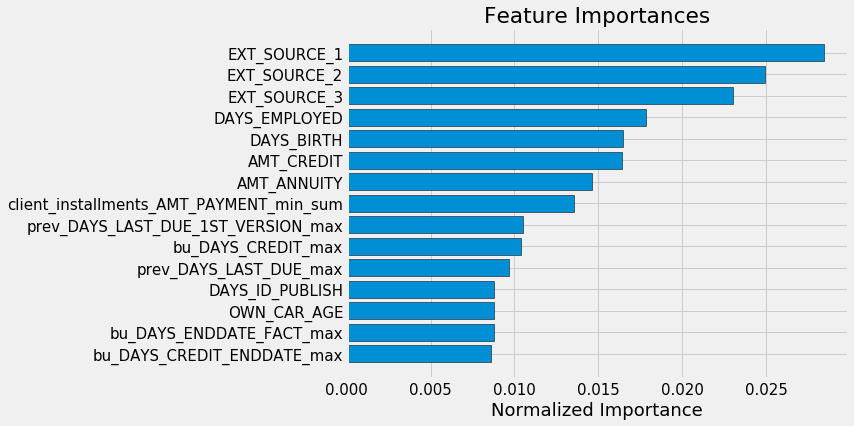

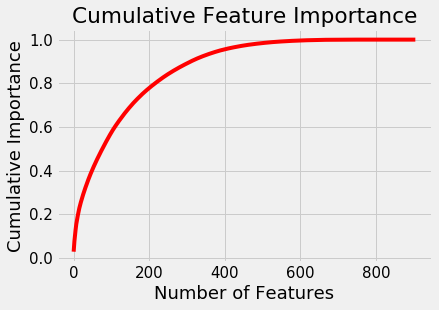

311 features required for 0.90 of cumulative importance


In [104]:
fi_sorted = plot_feature_importances(fi,0.9)

In [108]:
# Find the features with zero importance
zero_features = list(fi[fi['importance'] == 0.0]['feature'])
print('There are %d features with 0.0 importance' % len(zero_features))
fi.tail()

There are 186 features with 0.0 importance


,feature,importance
900,client_installments_AMT_PAYMENT_median_sum,41.0
901,client_installments_AMT_PAYMENT_sum_max,33.8
902,client_installments_AMT_PAYMENT_mean_sum,25.4
903,client_installments_AMT_INSTALMENT_max_sum,31.8
904,client_installments_AMT_PAYMENT_sum_sum,37.2


Let's remove the features with zero importance.

In [109]:
train = train.drop(columns = zero_features)
test = test.drop(columns = zero_features)

print('Training shape: ', train.shape)
print('Testing shape: ', test.shape)

Training shape:  (307511, 721)
Testing shape:  (48744, 720)


#### Repeated round removal
Around 700 features still look heavy for us. Let's run more rounds to remove zero feature importance features, and see the possibility to keep features with 95% cumulative feature importance. 

In [17]:
def identify_zero_importance_features(train, train_labels, iterations = 2):
    """
    Identify zero importance features in a training dataset based on the 
    feature importances from a gradient boosting model. 
    
    Parameters
    --------
    train : dataframe
        Training features
        
    train_labels : np.array
        Labels for training data
        
    iterations : integer, default = 2
        Number of cross validation splits to use for determining feature importances
    """
    
    # Initialize an empty array to hold feature importances
    feature_importances = np.zeros(train.shape[1])

    # Create the model with several hyperparameters
    model = lgb.LGBMClassifier(objective='binary', boosting_type = 'goss', n_estimators = 10000, class_weight = 'balanced')
    
    # Fit the model multiple times to avoid overfitting
    for i in range(iterations):

        # Split into training and validation set
        train_features, valid_features, train_y, valid_y = train_test_split(train, train_labels, test_size = 0.25, random_state = i)

        # Train using early stopping
        model.fit(train_features, train_y, early_stopping_rounds=100, eval_set = [(valid_features, valid_y)], 
                  eval_metric = 'auc', verbose = 200)

        # Record the feature importances
        feature_importances += model.feature_importances_ / iterations
    
    feature_importances = pd.DataFrame({'feature': list(train.columns), 'importance': feature_importances}).sort_values('importance', ascending = False)
    
    # Find the features with zero importance
    zero_features = list(feature_importances[feature_importances['importance'] == 0.0]['feature'])
    print('\nThere are %d features with 0.0 importance' % len(zero_features))
    
    return zero_features, feature_importances

In [175]:
second_round_zero_features, feature_importances = identify_zero_importance_features(train, train_target)

Training until validation scores don't improve for 100 rounds.
[200]	valid_0's auc: 0.780973
Early stopping, best iteration is:
[134]	valid_0's auc: 0.782583
Training until validation scores don't improve for 100 rounds.
[200]	valid_0's auc: 0.781951
Early stopping, best iteration is:
[133]	valid_0's auc: 0.783458

There are 153 features with 0.0 importance


In [177]:
# Find the features with zero importance
zero_features = list(feature_importances[feature_importances['importance'] == 0.0]['feature'])
print('There are %d features with 0.0 importance' % len(zero_features))
feature_importances.tail()

There are 153 features with 0.0 importance


,feature,importance
302,prev_NAME_GOODS_CATEGORY_Medicine_mean,0.0
301,prev_NAME_CASH_LOAN_PURPOSE_Building a house o...,0.0
300,prev_NAME_CONTRACT_TYPE_XNA_mean,0.0
299,prev_NAME_GOODS_CATEGORY_Weapon_mean,0.0
296,prev_NAME_CASH_LOAN_PURPOSE_Journey_mean,0.0


In [178]:
train = train.drop(columns = zero_features)
test = test.drop(columns = zero_features)

print('Training shape: ', train.shape)
print('Testing shape: ', test.shape)

Training shape:  (307511, 566)
Testing shape:  (48744, 566)


In [179]:
third_round_zero_features, feature_importances = identify_zero_importance_features(train, train_target)

Training until validation scores don't improve for 100 rounds.
[200]	valid_0's auc: 0.781548
Early stopping, best iteration is:
[134]	valid_0's auc: 0.782583
Training until validation scores don't improve for 100 rounds.
[200]	valid_0's auc: 0.782451
Early stopping, best iteration is:
[133]	valid_0's auc: 0.783458

There are 0 features with 0.0 importance


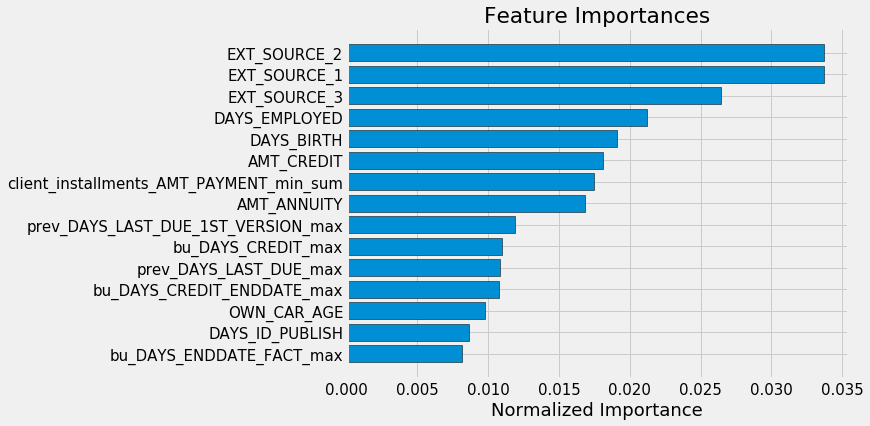

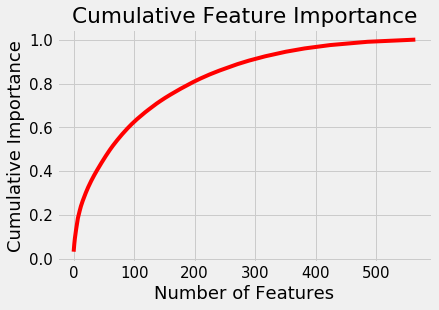

363 features required for 0.95 of cumulative importance


In [180]:
norm_feature_importances = plot_feature_importances(feature_importances, threshold = 0.95)

In [183]:
#train.to_csv('train_selected.csv', index = False)
#test.to_csv('test_selected.csv', index = False)

In [185]:
train['SK_ID_CURR'] = train_id_curr
train['TARGET'] = train_target
test['SK_ID_CURR'] = test_id_curr

submission, fi, metrics = model(train, test)
print('Baseline metrics')
print(metrics)

Training Data Shape:  (307511, 566)
Testing Data Shape:  (48744, 566)
Training until validation scores don't improve for 100 rounds.
[200]	valid's auc: 0.782469	train's auc: 0.83014
[400]	valid's auc: 0.784291	train's auc: 0.86748
Early stopping, best iteration is:
[375]	valid's auc: 0.784471	train's auc: 0.863622
Training until validation scores don't improve for 100 rounds.
[200]	valid's auc: 0.786645	train's auc: 0.829677
[400]	valid's auc: 0.787805	train's auc: 0.867254
Early stopping, best iteration is:
[315]	valid's auc: 0.78796	train's auc: 0.852741
Training until validation scores don't improve for 100 rounds.
[200]	valid's auc: 0.777425	train's auc: 0.830933
[400]	valid's auc: 0.779799	train's auc: 0.868268
Early stopping, best iteration is:
[415]	valid's auc: 0.779903	train's auc: 0.870656
Training until validation scores don't improve for 100 rounds.
[200]	valid's auc: 0.784186	train's auc: 0.829933
[400]	valid's auc: 0.785807	train's auc: 0.867712
Early stopping, best itera

Let's check the possibility of 95% cumulation.

In [181]:
# Threshold for cumulative importance
threshold = 0.95

# Extract the features to keep
features_to_keep = list(norm_feature_importances[norm_feature_importances['cumulative_importance'] < threshold]['feature'])

# Create new datasets with smaller features
train_small = train[features_to_keep]
test_small = test[features_to_keep]

In [182]:
train_small['TARGET'] = train_target
train_small['SK_ID_CURR'] = train_id_curr
test_small['SK_ID_CURR'] = test_id_curr

In [187]:
submission, fi, metrics = model(train_small, test_small)
print('Baseline metrics')
print(metrics)

Training Data Shape:  (307511, 362)
Testing Data Shape:  (48744, 362)
Training until validation scores don't improve for 100 rounds.
[200]	valid's auc: 0.782361	train's auc: 0.829815
[400]	valid's auc: 0.783281	train's auc: 0.867262
Early stopping, best iteration is:
[350]	valid's auc: 0.783487	train's auc: 0.858885
Training until validation scores don't improve for 100 rounds.
[200]	valid's auc: 0.786357	train's auc: 0.829856
[400]	valid's auc: 0.788689	train's auc: 0.86745
[600]	valid's auc: 0.788519	train's auc: 0.895968
Early stopping, best iteration is:
[500]	valid's auc: 0.788864	train's auc: 0.882672
Training until validation scores don't improve for 100 rounds.
[200]	valid's auc: 0.777826	train's auc: 0.830646
[400]	valid's auc: 0.780396	train's auc: 0.868181
Early stopping, best iteration is:
[430]	valid's auc: 0.780591	train's auc: 0.872715
Training until validation scores don't improve for 100 rounds.
[200]	valid's auc: 0.784512	train's auc: 0.829674
[400]	valid's auc: 0.786

Here, we can see the smaller feature set of 95% cumulative feature importance is even better than the larger set. Thus the larger set is abandaned.

In [190]:
train_small.to_csv('train_small.csv', index = False)
test_small.to_csv('test_small.csv', index = False)

In [191]:
train = train_small
test = test_small

## Feature Engineering

### 1. Polynomial Features
In this method, we make features that are powers of existing features as well as interaction terms between existing features. While two variables by themselves may not have a strong influence on the target, combining them together into a single interaction variable might show a relationship with the target. *PolynomialFeatures* from *Scikit-Learn* is a useful class to realize this.

In [74]:
# Make a new dataframe for polynomial features
poly_features = train[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH', 'TARGET']]
poly_features_test = test[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH']]

# imputer for handling missing values
from sklearn.preprocessing import Imputer
imputer = Imputer(strategy = 'median')

poly_target = poly_features['TARGET']

poly_features = poly_features.drop(columns = ['TARGET'])

# Need to impute missing values
poly_features = imputer.fit_transform(poly_features)
poly_features_test = imputer.transform(poly_features_test)

from sklearn.preprocessing import PolynomialFeatures
                                  
# Create the polynomial object with specified degree
poly_transformer = PolynomialFeatures(degree = 2)

In [75]:
# Train the polynomial features
poly_transformer.fit(poly_features)

# Transform the features
poly_features = poly_transformer.transform(poly_features)
poly_features_test = poly_transformer.transform(poly_features_test)
print('Polynomial Features shape: ', poly_features.shape)

Polynomial Features shape:  (307511, 15)


There are 15 features with individual features raised to powers up to degree 2 and interaction terms. Now, we can see whether any of these new features are correlated with the target.

In [76]:
# Check the names
poly_transformer.get_feature_names(input_features = ['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH'])[:15]

['1',
 'EXT_SOURCE_1',
 'EXT_SOURCE_2',
 'EXT_SOURCE_3',
 'DAYS_BIRTH',
 'EXT_SOURCE_1^2',
 'EXT_SOURCE_1 EXT_SOURCE_2',
 'EXT_SOURCE_1 EXT_SOURCE_3',
 'EXT_SOURCE_1 DAYS_BIRTH',
 'EXT_SOURCE_2^2',
 'EXT_SOURCE_2 EXT_SOURCE_3',
 'EXT_SOURCE_2 DAYS_BIRTH',
 'EXT_SOURCE_3^2',
 'EXT_SOURCE_3 DAYS_BIRTH',
 'DAYS_BIRTH^2']

In [77]:
# Create a dataframe of the features 
poly_features = pd.DataFrame(poly_features, 
                             columns = poly_transformer.get_feature_names(['EXT_SOURCE_1', 'EXT_SOURCE_2', 
                                                                           'EXT_SOURCE_3', 'DAYS_BIRTH']))

# Add in the target
poly_features['TARGET'] = poly_target

# Find the correlations with the target
poly_corrs = poly_features.corr()['TARGET'].sort_values()

# Display most negative and most positive
print(poly_corrs.head(10))
print(poly_corrs.tail(5))

EXT_SOURCE_2 EXT_SOURCE_3   -0.193939
EXT_SOURCE_1 EXT_SOURCE_2   -0.166625
EXT_SOURCE_1 EXT_SOURCE_3   -0.164065
EXT_SOURCE_2                -0.160295
EXT_SOURCE_2 DAYS_BIRTH     -0.156873
EXT_SOURCE_3                -0.155892
EXT_SOURCE_3 DAYS_BIRTH     -0.150109
EXT_SOURCE_2^2              -0.149512
EXT_SOURCE_3^2              -0.141662
EXT_SOURCE_1 DAYS_BIRTH     -0.104882
Name: TARGET, dtype: float64
EXT_SOURCE_1^2   -0.091034
DAYS_BIRTH       -0.078239
DAYS_BIRTH^2     -0.076672
TARGET            1.000000
1                      NaN
Name: TARGET, dtype: float64


Several of the new variables have a greater (in terms of absolute magnitude) correlation with the target than the original features. When we build machine learning models, we can try with and without these features to determine if they actually help the model learn.

We will add these features to a copy of the training and testing data and then evaluate models with and without the features. 

In [78]:
# Put test features into dataframe
poly_features_test = pd.DataFrame(poly_features_test, 
                                  columns = poly_transformer.get_feature_names(['EXT_SOURCE_1', 'EXT_SOURCE_2', 
                                                                                'EXT_SOURCE_3', 'DAYS_BIRTH']))

# Merge polynomial features into training dataframe
poly_features['SK_ID_CURR'] = train['SK_ID_CURR']
train_poly = train.merge(poly_features, on = 'SK_ID_CURR', how = 'left')

# Merge polnomial features into testing dataframe
poly_features_test['SK_ID_CURR'] = test['SK_ID_CURR']
test_poly = test.merge(poly_features_test, on = 'SK_ID_CURR', how = 'left')

# Align the dataframes
train_poly, test_poly = train_poly.align(test_poly, join = 'inner', axis = 1)

# Add TARGET back to train
train_poly['TARGET'] = train_target

# Print out the new shapes
print('Training data with polynomial features shape: ', train_poly.shape)
print('Testing data with polynomial features shape:  ', test_poly.shape)

Training data with polynomial features shape:  (307511, 1779)
Testing data with polynomial features shape:   (48744, 1778)


### 2. Domain Knowledge Features
* CREDIT_INCOME_PERCENT: the percentage of the credit amount relative to a client's income
* ANNUITY_INCOME_PERCENT: the percentage of the loan annuity relative to a client's income
* CREDIT_TERM: the length of the payment in months (since the annuity is the monthly amount due
* DAYS_EMPLOYED_PERCENT: the percentage of the days employed relative to the client's age
* INCOME_PER_PERSON: the total income relative to the number of family number

In [204]:
#train_domain = train.copy()
#test_domain = test.copy()

train['CREDIT_INCOME_PERCENT'] = train['AMT_CREDIT'] / train['AMT_INCOME_TOTAL']
train['ANNUITY_INCOME_PERCENT'] = train['AMT_ANNUITY'] / train['AMT_INCOME_TOTAL']
train['CREDIT_TERM'] = train['AMT_ANNUITY'] / train['AMT_CREDIT']
train['DAYS_EMPLOYED_PERCENT'] = train['DAYS_EMPLOYED'] / train['DAYS_BIRTH']
train['INCOME_PER_PERSON'] = train['AMT_INCOME_TOTAL'] / cc['CNT_FAM_MEMBERS']

In [205]:
test['CREDIT_INCOME_PERCENT'] = test['AMT_CREDIT'] / test['AMT_INCOME_TOTAL']
test['ANNUITY_INCOME_PERCENT'] = test['AMT_ANNUITY'] / test['AMT_INCOME_TOTAL']
test['CREDIT_TERM'] = test['AMT_ANNUITY'] / test['AMT_CREDIT']
test['DAYS_EMPLOYED_PERCENT'] = test['DAYS_EMPLOYED'] / test['DAYS_BIRTH']
test['INCOME_PER_PERSON'] = test['AMT_INCOME_TOTAL'] / cc_t['CNT_FAM_MEMBERS']

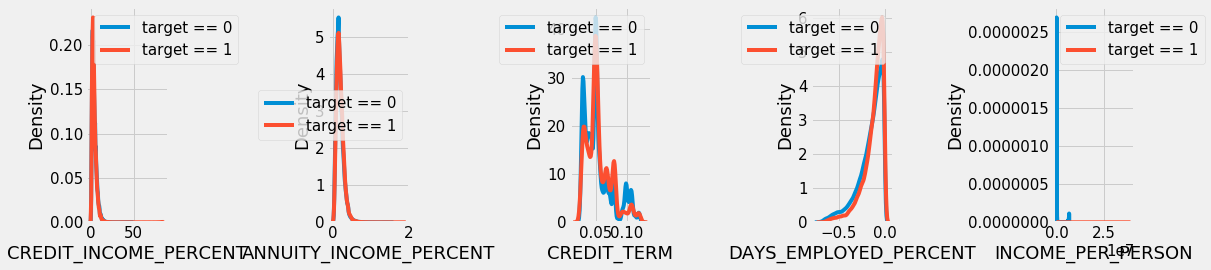

In [208]:
plt.figure(figsize = (16, 4))
# iterate through the new features
for i, feature in enumerate(['CREDIT_INCOME_PERCENT', 'ANNUITY_INCOME_PERCENT', 'CREDIT_TERM', 
                             'DAYS_EMPLOYED_PERCENT','INCOME_PER_PERSON']):
    
    # create a new subplot for each source
    plt.subplot(1, 5, i + 1)
    # plot repaid loans
    sns.kdeplot(train.loc[train['TARGET'] == 0, feature], label = 'target == 0')
    # plot loans that were not repaid
    sns.kdeplot(train.loc[train['TARGET'] == 1, feature], label = 'target == 1')
    
    # Label the plots
    plt.xlabel('%s' % feature); plt.ylabel('Density');
    
plt.tight_layout(h_pad = 2.5)

In [209]:
submission, fi, metrics = model(train, test)
print('Baseline metrics')
print(metrics)

Training Data Shape:  (307511, 367)
Testing Data Shape:  (48744, 367)
Training until validation scores don't improve for 100 rounds.
[200]	valid's auc: 0.784635	train's auc: 0.832546
[400]	valid's auc: 0.786757	train's auc: 0.869821
Early stopping, best iteration is:
[434]	valid's auc: 0.786885	train's auc: 0.875206
Training until validation scores don't improve for 100 rounds.
[200]	valid's auc: 0.790108	train's auc: 0.831366
[400]	valid's auc: 0.791853	train's auc: 0.869256
Early stopping, best iteration is:
[332]	valid's auc: 0.792118	train's auc: 0.857459
Training until validation scores don't improve for 100 rounds.
[200]	valid's auc: 0.77998	train's auc: 0.832735
[400]	valid's auc: 0.782628	train's auc: 0.869848
[600]	valid's auc: 0.783345	train's auc: 0.898427
Early stopping, best iteration is:
[632]	valid's auc: 0.783453	train's auc: 0.902175
Training until validation scores don't improve for 100 rounds.
[200]	valid's auc: 0.786331	train's auc: 0.831629
[400]	valid's auc: 0.787

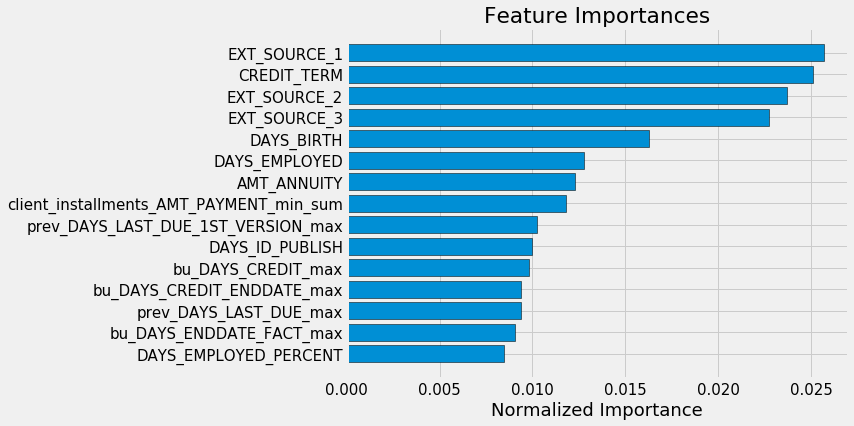

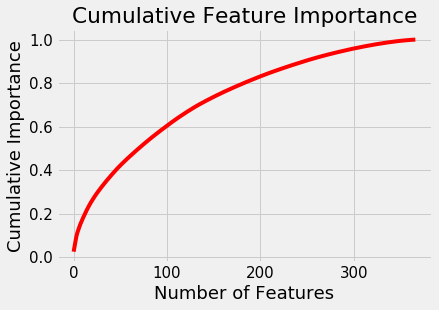

292 features required for 0.95 of cumulative importance


In [212]:
fi_sorted = plot_feature_importances(fi,0.95)

Let's further reduce the feature size by limit to 95% cumulative feature importance.

In [214]:
# Threshold for cumulative importance
threshold = 0.95

# Extract the features to keep
features_to_keep = list(fi_sorted[fi_sorted['cumulative_importance'] < threshold]['feature'])

# Create new datasets with smaller features
train_small = train[features_to_keep]
test_small = test[features_to_keep]

In [215]:
train_small['TARGET'] = train_target
train_small['SK_ID_CURR'] = train_id_curr
test_small['SK_ID_CURR'] = test_id_curr

In [216]:
submission, fi, metrics = model(train_small, test_small)
print('Baseline metrics')
print(metrics)

Training Data Shape:  (307511, 291)
Testing Data Shape:  (48744, 291)
Training until validation scores don't improve for 100 rounds.
[200]	valid's auc: 0.784574	train's auc: 0.831762
[400]	valid's auc: 0.786412	train's auc: 0.869211
Early stopping, best iteration is:
[403]	valid's auc: 0.786423	train's auc: 0.869693
Training until validation scores don't improve for 100 rounds.
[200]	valid's auc: 0.788853	train's auc: 0.830927
[400]	valid's auc: 0.79098	train's auc: 0.868905
Early stopping, best iteration is:
[405]	valid's auc: 0.791095	train's auc: 0.869802
Training until validation scores don't improve for 100 rounds.
[200]	valid's auc: 0.780302	train's auc: 0.832474
[400]	valid's auc: 0.782857	train's auc: 0.8697
Early stopping, best iteration is:
[417]	valid's auc: 0.78309	train's auc: 0.872447
Training until validation scores don't improve for 100 rounds.
[200]	valid's auc: 0.786183	train's auc: 0.831359
[400]	valid's auc: 0.787985	train's auc: 0.868722
Early stopping, best iterat

We can see the results are almost the same. So use it.

In [217]:
train = train_small
test = test_small

In [2]:
#train.to_csv('train_293.csv', index = False)
#test.to_csv('test_292.csv', index = False)
train = pd.read_csv('./train_293.csv')
test = pd.read_csv('./test_292.csv')

#### Re-process the feature of **LATE_PAYMENT**, since it isn't converted to object earlier. Also with some other features of Installment Payment dataframe.

In [3]:
ins_pay = pd.read_csv('./all/installments_payments.csv')

In [4]:
ins_pay['LATE_PAYMENT'] = ((pd.to_timedelta(ins_pay['DAYS_ENTRY_PAYMENT'], 'D') - pd.to_timedelta(ins_pay['DAYS_INSTALMENT'], 'D')).astype(int)
                           > 0).astype(int).astype('object')

In [5]:
ins_pay['PAYMENT_PERC'] = ins_pay['AMT_PAYMENT'] / ins_pay['AMT_INSTALMENT']
ins_pay['PAYMENT_DIFF'] = ins_pay['AMT_INSTALMENT'] - ins_pay['AMT_PAYMENT']
# Days past due and days before due (no negative values)
ins_pay['DPD'] = ins_pay['DAYS_ENTRY_PAYMENT'] - ins_pay['DAYS_INSTALMENT']
ins_pay['DBD'] = ins_pay['DAYS_INSTALMENT'] - ins_pay['DAYS_ENTRY_PAYMENT']
ins_pay['DPD'] = ins_pay['DPD'].apply(lambda x: x if x > 0 else 0)
ins_pay['DBD'] = ins_pay['DBD'].apply(lambda x: x if x > 0 else 0)

In [6]:
ins_pay = ins_pay[['SK_ID_PREV','SK_ID_CURR','LATE_PAYMENT','PAYMENT_PERC','PAYMENT_DIFF','DPD','DBD']]

In [7]:
ins_pay.head()

,SK_ID_PREV,SK_ID_CURR,LATE_PAYMENT,PAYMENT_PERC,PAYMENT_DIFF,DPD,DBD
0,1054186,161674,0,1.000000,0.000,0.0,7.0
1,1330831,151639,0,1.000000,0.000,0.0,0.0
2,2085231,193053,0,1.000000,0.000,0.0,0.0
3,2452527,199697,0,1.000000,0.000,0.0,8.0
4,2714724,167756,1,0.997942,4.455,17.0,0.0


In [18]:
ins_pay = convert_types(ins_pay, print_info=True)
ins_pay_1 = count_categorical(ins_pay, 'SK_ID_CURR', 'ins')

Original Memory Usage: 0.76 gb.
New Memory Usage: 0.34 gb.


In [19]:
ins_pay_2 = agg_numeric(ins_pay, 'SK_ID_CURR', 'ins')

In [20]:
train = train.merge(ins_pay_1, on = 'SK_ID_CURR', how = 'left')
test = test.merge(ins_pay_1, on = 'SK_ID_CURR', how = 'left')
train = train.merge(ins_pay_2, on = 'SK_ID_CURR', how = 'left')
test = test.merge(ins_pay_2, on = 'SK_ID_CURR', how = 'left')

In [21]:
import gc
gc.enable()
del ins_pay, ins_pay_1, ins_pay_2
gc.collect()

print('Training shape: ', train.shape)
print('Testing shape: ', test.shape)

Training shape:  (307511, 318)
Testing shape:  (48744, 317)


#### Keeps adding new features (refer to people's Kernel):

In [22]:
cc = pd.read_csv('./all/application_train.csv')
cc_t = pd.read_csv('./all/application_test.csv')

In [23]:
docs = [_f for _f in cc.columns if 'FLAG_DOC' in _f]
live = [_f for _f in cc.columns if ('FLAG_' in _f) & ('FLAG_DOC' not in _f) & ('_FLAG_' not in _f)]
docs_t = [_f for _f in cc_t.columns if 'FLAG_DOC' in _f]
live_t = [_f for _f in cc_t.columns if ('FLAG_' in _f) & ('FLAG_DOC' not in _f) & ('_FLAG_' not in _f)]

In [24]:
inc_by_org = cc[['AMT_INCOME_TOTAL', 'ORGANIZATION_TYPE']].groupby('ORGANIZATION_TYPE').median()['AMT_INCOME_TOTAL']
train['NEW_CREDIT_TO_ANNUITY_RATIO'] = cc['AMT_CREDIT'] / cc['AMT_ANNUITY']
train['NEW_CREDIT_TO_GOODS_RATIO'] = cc['AMT_CREDIT'] / cc['AMT_GOODS_PRICE']
train['NEW_INC_PER_CHLD'] = cc['AMT_INCOME_TOTAL'] / (1 + cc['CNT_CHILDREN'])
train['NEW_INC_BY_ORG'] = cc['ORGANIZATION_TYPE'].map(inc_by_org)
train['NEW_EMPLOY_TO_BIRTH_RATIO'] = train['DAYS_EMPLOYED'] / train['DAYS_BIRTH']
train['NEW_ANNUITY_TO_INCOME_RATIO'] = cc['AMT_ANNUITY'] / (1 + train['AMT_INCOME_TOTAL'])
train['NEW_SOURCES_PROD'] = train['EXT_SOURCE_1'] * train['EXT_SOURCE_2'] * train['EXT_SOURCE_3']
train['NEW_EXT_SOURCES_MEAN'] = train[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']].mean(axis=1)
train['NEW_SCORES_STD'] = train[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']].std(axis=1)
train['NEW_SCORES_STD'] = train['NEW_SCORES_STD'].fillna(train['NEW_SCORES_STD'].mean())
train['NEW_CAR_TO_BIRTH_RATIO'] = train['OWN_CAR_AGE'] / train['DAYS_BIRTH']
train['NEW_CAR_TO_EMPLOY_RATIO'] = train['OWN_CAR_AGE'] / train['DAYS_EMPLOYED']
train['NEW_PHONE_TO_BIRTH_RATIO'] = train['DAYS_LAST_PHONE_CHANGE'] / train['DAYS_BIRTH']
train['NEW_PHONE_TO_EMPLOY_RATIO'] = train['DAYS_LAST_PHONE_CHANGE'] / train['DAYS_EMPLOYED']
train['NEW_CREDIT_TO_INCOME_RATIO'] = train['AMT_CREDIT'] / train['AMT_INCOME_TOTAL']
train['NEW_DOC_IND_AVG'] = cc[docs].mean(axis=1)
train['NEW_DOC_IND_STD'] = cc[docs].std(axis=1)
train['NEW_DOC_IND_KURT'] = cc[docs].kurtosis(axis=1)
train['NEW_LIVE_IND_SUM'] = cc[live].sum(axis=1)
train['NEW_LIVE_IND_STD'] = cc[live].std(axis=1)

In [25]:
inc_by_org = cc_t[['AMT_INCOME_TOTAL', 'ORGANIZATION_TYPE']].groupby('ORGANIZATION_TYPE').median()['AMT_INCOME_TOTAL']
test['NEW_CREDIT_TO_ANNUITY_RATIO'] = cc_t['AMT_CREDIT'] / cc_t['AMT_ANNUITY']
test['NEW_CREDIT_TO_GOODS_RATIO'] = cc_t['AMT_CREDIT'] / cc_t['AMT_GOODS_PRICE']
test['NEW_INC_PER_CHLD'] = cc_t['AMT_INCOME_TOTAL'] / (1 + cc_t['CNT_CHILDREN'])
test['NEW_INC_BY_ORG'] = cc_t['ORGANIZATION_TYPE'].map(inc_by_org)
test['NEW_EMPLOY_TO_BIRTH_RATIO'] = test['DAYS_EMPLOYED'] / test['DAYS_BIRTH']
test['NEW_ANNUITY_TO_INCOME_RATIO'] = cc_t['AMT_ANNUITY'] / (1 + test['AMT_INCOME_TOTAL'])
test['NEW_SOURCES_PROD'] = test['EXT_SOURCE_1'] * test['EXT_SOURCE_2'] * test['EXT_SOURCE_3']
test['NEW_EXT_SOURCES_MEAN'] = test[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']].mean(axis=1)
test['NEW_SCORES_STD'] = test[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']].std(axis=1)
test['NEW_SCORES_STD'] = test['NEW_SCORES_STD'].fillna(test['NEW_SCORES_STD'].mean())
test['NEW_CAR_TO_BIRTH_RATIO'] = test['OWN_CAR_AGE'] / test['DAYS_BIRTH']
test['NEW_CAR_TO_EMPLOY_RATIO'] = test['OWN_CAR_AGE'] / test['DAYS_EMPLOYED']
test['NEW_PHONE_TO_BIRTH_RATIO'] = test['DAYS_LAST_PHONE_CHANGE'] / test['DAYS_BIRTH']
test['NEW_PHONE_TO_EMPLOY_RATIO'] = test['DAYS_LAST_PHONE_CHANGE'] / test['DAYS_EMPLOYED']
test['NEW_CREDIT_TO_INCOME_RATIO'] = test['AMT_CREDIT'] / test['AMT_INCOME_TOTAL']
test['NEW_DOC_IND_AVG'] = cc_t[docs].mean(axis=1)
test['NEW_DOC_IND_STD'] = cc_t[docs].std(axis=1)
test['NEW_DOC_IND_KURT'] = cc_t[docs].kurtosis(axis=1)
test['NEW_LIVE_IND_SUM'] = cc_t[live].sum(axis=1)
test['NEW_LIVE_IND_STD'] = cc_t[live].std(axis=1)

In [26]:
for bin_feature in ['FLAG_OWN_CAR', 'FLAG_OWN_REALTY']:
    train[bin_feature], uniques = pd.factorize(cc[bin_feature])
for bin_feature in ['FLAG_OWN_CAR', 'FLAG_OWN_REALTY']:
    test[bin_feature], uniques = pd.factorize(cc_t[bin_feature])

In [27]:
gc.enable()
del cc, cc_t
gc.collect()

print('Training shape: ', train.shape)
print('Testing shape: ', test.shape)

Training shape:  (307511, 339)
Testing shape:  (48744, 338)


In [40]:
submission, fi, metrics = model(train, test, n_folds=2)
print('Baseline metrics')
print(metrics)

Training Data Shape:  (307511, 337)
Testing Data Shape:  (48744, 337)
Training until validation scores don't improve for 100 rounds.
[200]	valid's auc: 0.783289	train's auc: 0.854868
Early stopping, best iteration is:
[265]	valid's auc: 0.784091	train's auc: 0.873275
Training until validation scores don't improve for 100 rounds.
[200]	valid's auc: 0.783658	train's auc: 0.854926
[400]	valid's auc: 0.783757	train's auc: 0.902964
Early stopping, best iteration is:
[353]	valid's auc: 0.784159	train's auc: 0.89345
Baseline metrics
      fold     train     valid
0        0  0.873275  0.784091
1        1  0.893450  0.784159
2  overall  0.883362  0.784071


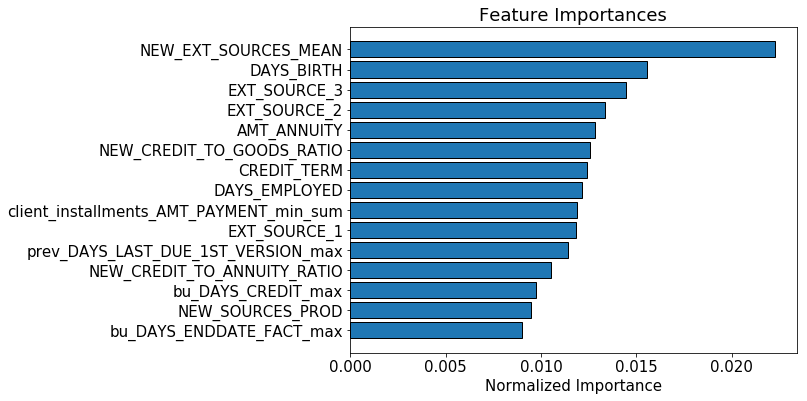

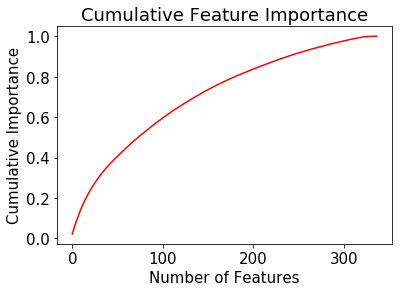

277 features required for 0.95 of cumulative importance


In [41]:
fi_sorted = plot_feature_importances(fi,0.95)

In [43]:
# Find the features with zero importance
zero_features = list(fi[fi['importance'] == 0.0]['feature'])
print('There are %d features with 0.0 importance' % len(zero_features))
fi.tail()

There are 5 features with 0.0 importance


,feature,importance
332,NEW_DOC_IND_KURT,24.0
333,NEW_LIVE_IND_SUM,3.0
334,NEW_LIVE_IND_STD,2.0
335,FLAG_OWN_CAR,0.0
336,FLAG_OWN_REALTY,2.5


In [46]:
train_small = train.drop(columns = zero_features)
test_small = test.drop(columns = zero_features)

print('Training shape: ', train_small.shape)
print('Testing shape: ', test_small.shape)

Training shape:  (307511, 334)
Testing shape:  (48744, 333)


In [45]:
submission1, fi1, metrics1 = model(train_small, test_small)
print('Baseline metrics')
print(metrics1)

Training Data Shape:  (307511, 332)
Testing Data Shape:  (48744, 332)
Training until validation scores don't improve for 100 rounds.
[200]	valid's auc: 0.785009	train's auc: 0.833286
[400]	valid's auc: 0.786846	train's auc: 0.871418
Early stopping, best iteration is:
[378]	valid's auc: 0.78698	train's auc: 0.867769
Training until validation scores don't improve for 100 rounds.
[200]	valid's auc: 0.790159	train's auc: 0.832871
[400]	valid's auc: 0.792147	train's auc: 0.87102
Early stopping, best iteration is:
[381]	valid's auc: 0.792253	train's auc: 0.868048
Training until validation scores don't improve for 100 rounds.
[200]	valid's auc: 0.780906	train's auc: 0.834083
[400]	valid's auc: 0.783235	train's auc: 0.871856
Early stopping, best iteration is:
[360]	valid's auc: 0.783528	train's auc: 0.865107
Training until validation scores don't improve for 100 rounds.
[200]	valid's auc: 0.787863	train's auc: 0.833353
[400]	valid's auc: 0.79023	train's auc: 0.871543
Early stopping, best itera

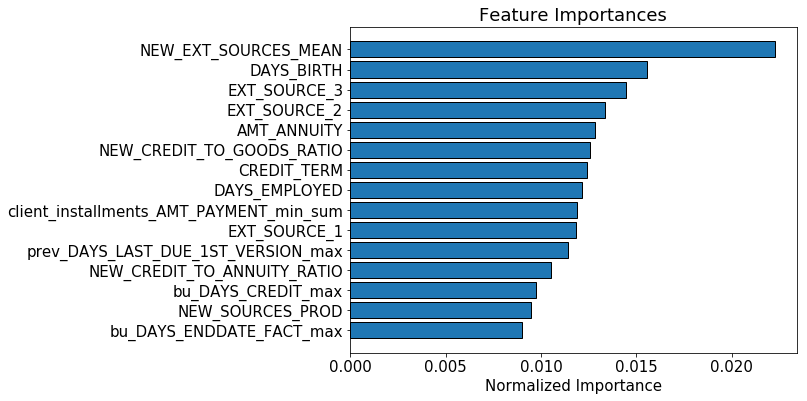

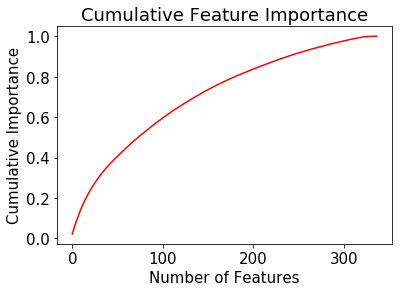

277 features required for 0.95 of cumulative importance


In [47]:
fi_sorted = plot_feature_importances(fi,0.95)

In [48]:
#train_small.to_csv('./train_334.csv')
#test_small.to_csv('./test_333.csv')

#### Further feature engineering
##### Application

In [409]:
cc = pd.read_csv('./all/application_train.csv')
cc_t = pd.read_csv('./all/application_test.csv')

In [410]:
train['app missing'] = cc.isnull().sum(axis = 1).values

train['app EXT_SOURCE std'] = cc[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']].std(axis = 1)
train['app EXT_SOURCE prod'] = cc['EXT_SOURCE_1'] * cc['EXT_SOURCE_2'] * cc['EXT_SOURCE_3']
train['app EXT_SOURCE_1 * EXT_SOURCE_2'] = cc['EXT_SOURCE_1'] * cc['EXT_SOURCE_2']
train['app EXT_SOURCE_1 * EXT_SOURCE_3'] = cc['EXT_SOURCE_1'] * cc['EXT_SOURCE_3']
train['app EXT_SOURCE_2 * EXT_SOURCE_3'] = cc['EXT_SOURCE_2'] * cc['EXT_SOURCE_3']
train['app EXT_SOURCE_1 * DAYS_EMPLOYED'] = cc['EXT_SOURCE_1'] * cc['DAYS_EMPLOYED']
train['app EXT_SOURCE_2 * DAYS_EMPLOYED'] = cc['EXT_SOURCE_2'] * cc['DAYS_EMPLOYED']
train['app EXT_SOURCE_3 * DAYS_EMPLOYED'] = cc['EXT_SOURCE_3'] * cc['DAYS_EMPLOYED']
train['app EXT_SOURCE_1 / DAYS_BIRTH'] = cc['EXT_SOURCE_1'] / cc['DAYS_BIRTH']
train['app EXT_SOURCE_2 / DAYS_BIRTH'] = cc['EXT_SOURCE_2'] / cc['DAYS_BIRTH']
train['app EXT_SOURCE_3 / DAYS_BIRTH'] = cc['EXT_SOURCE_3'] / cc['DAYS_BIRTH']

train['app AMT_CREDIT - AMT_GOODS_PRICE'] = cc['AMT_CREDIT'] - cc['AMT_GOODS_PRICE']
train['app AMT_CREDIT / AMT_GOODS_PRICE'] = cc['AMT_CREDIT'] / cc['AMT_GOODS_PRICE']
train['app AMT_CREDIT / AMT_ANNUITY'] = cc['AMT_CREDIT'] / cc['AMT_ANNUITY']
train['app AMT_CREDIT / AMT_INCOME_TOTAL'] = cc['AMT_CREDIT'] / cc['AMT_INCOME_TOTAL']

train['app AMT_INCOME_TOTAL / 12 - AMT_ANNUITY'] = cc['AMT_INCOME_TOTAL'] / 12. - cc['AMT_ANNUITY']
train['app AMT_INCOME_TOTAL / AMT_ANNUITY'] = cc['AMT_INCOME_TOTAL'] / cc['AMT_ANNUITY']
train['app AMT_INCOME_TOTAL - AMT_GOODS_PRICE'] = cc['AMT_INCOME_TOTAL'] - cc['AMT_GOODS_PRICE']
train['app AMT_INCOME_TOTAL / CNT_FAM_MEMBERS'] = cc['AMT_INCOME_TOTAL'] / cc['CNT_FAM_MEMBERS']
train['app AMT_INCOME_TOTAL / CNT_CHILDREN'] = cc['AMT_INCOME_TOTAL'] / (1 + cc['CNT_CHILDREN'])

train['app most popular AMT_GOODS_PRICE'] = cc['AMT_GOODS_PRICE'] \
                .isin([225000, 450000, 675000, 900000]).map({True: 1, False: 0})
train['app popular AMT_GOODS_PRICE'] = cc['AMT_GOODS_PRICE'] \
                .isin([1125000, 1350000, 1575000, 1800000, 2250000]).map({True: 1, False: 0})

train['app OWN_CAR_AGE / DAYS_BIRTH'] = train['OWN_CAR_AGE'] / train['DAYS_BIRTH']
train['app OWN_CAR_AGE / DAYS_EMPLOYED'] = train['OWN_CAR_AGE'] / train['DAYS_EMPLOYED']

train['app DAYS_LAST_PHONE_CHANGE / DAYS_BIRTH'] = train['DAYS_LAST_PHONE_CHANGE'] / train['DAYS_BIRTH']
train['app DAYS_LAST_PHONE_CHANGE / DAYS_EMPLOYED'] = train['DAYS_LAST_PHONE_CHANGE'] / train['DAYS_EMPLOYED']
train['app DAYS_EMPLOYED - DAYS_BIRTH'] = train['DAYS_EMPLOYED'] - train['DAYS_BIRTH']
train['app DAYS_EMPLOYED / DAYS_BIRTH'] = train['DAYS_EMPLOYED'] / train['DAYS_BIRTH']

train['app CNT_CHILDREN / CNT_FAM_MEMBERS'] = cc['CNT_CHILDREN'] / cc['CNT_FAM_MEMBERS']

In [411]:
test['app missing'] = cc_t.isnull().sum(axis = 1).values

test['app EXT_SOURCE std'] = cc_t[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']].std(axis = 1)
test['app EXT_SOURCE prod'] = cc_t['EXT_SOURCE_1'] * cc_t['EXT_SOURCE_2'] * cc_t['EXT_SOURCE_3']
test['app EXT_SOURCE_1 * EXT_SOURCE_2'] = cc_t['EXT_SOURCE_1'] * cc_t['EXT_SOURCE_2']
test['app EXT_SOURCE_1 * EXT_SOURCE_3'] = cc_t['EXT_SOURCE_1'] * cc_t['EXT_SOURCE_3']
test['app EXT_SOURCE_2 * EXT_SOURCE_3'] = cc_t['EXT_SOURCE_2'] * cc_t['EXT_SOURCE_3']
test['app EXT_SOURCE_1 * DAYS_EMPLOYED'] = cc_t['EXT_SOURCE_1'] * cc_t['DAYS_EMPLOYED']
test['app EXT_SOURCE_2 * DAYS_EMPLOYED'] = cc_t['EXT_SOURCE_2'] * cc_t['DAYS_EMPLOYED']
test['app EXT_SOURCE_3 * DAYS_EMPLOYED'] = cc_t['EXT_SOURCE_3'] * cc_t['DAYS_EMPLOYED']
test['app EXT_SOURCE_1 / DAYS_BIRTH'] = cc_t['EXT_SOURCE_1'] / cc_t['DAYS_BIRTH']
test['app EXT_SOURCE_2 / DAYS_BIRTH'] = cc_t['EXT_SOURCE_2'] / cc_t['DAYS_BIRTH']
test['app EXT_SOURCE_3 / DAYS_BIRTH'] = cc_t['EXT_SOURCE_3'] / cc_t['DAYS_BIRTH']

test['app AMT_CREDIT - AMT_GOODS_PRICE'] = cc_t['AMT_CREDIT'] - cc_t['AMT_GOODS_PRICE']
test['app AMT_CREDIT / AMT_GOODS_PRICE'] = cc_t['AMT_CREDIT'] / cc_t['AMT_GOODS_PRICE']
test['app AMT_CREDIT / AMT_ANNUITY'] = cc_t['AMT_CREDIT'] / cc_t['AMT_ANNUITY']
test['app AMT_CREDIT / AMT_INCOME_TOTAL'] = cc_t['AMT_CREDIT'] / cc_t['AMT_INCOME_TOTAL']

test['app AMT_INCOME_TOTAL / 12 - AMT_ANNUITY'] = cc_t['AMT_INCOME_TOTAL'] / 12. - cc_t['AMT_ANNUITY']
test['app AMT_INCOME_TOTAL / AMT_ANNUITY'] = cc_t['AMT_INCOME_TOTAL'] / cc_t['AMT_ANNUITY']
test['app AMT_INCOME_TOTAL - AMT_GOODS_PRICE'] = cc_t['AMT_INCOME_TOTAL'] - cc_t['AMT_GOODS_PRICE']
test['app AMT_INCOME_TOTAL / CNT_FAM_MEMBERS'] = cc_t['AMT_INCOME_TOTAL'] / cc_t['CNT_FAM_MEMBERS']
test['app AMT_INCOME_TOTAL / CNT_CHILDREN'] = cc_t['AMT_INCOME_TOTAL'] / (1 + cc_t['CNT_CHILDREN'])

test['app most popular AMT_GOODS_PRICE'] = cc_t['AMT_GOODS_PRICE'] \
                .isin([225000, 450000, 675000, 900000]).map({True: 1, False: 0})
test['app popular AMT_GOODS_PRICE'] = cc_t['AMT_GOODS_PRICE'] \
                .isin([1125000, 1350000, 1575000, 1800000, 2250000]).map({True: 1, False: 0})

test['app OWN_CAR_AGE / DAYS_BIRTH'] = test['OWN_CAR_AGE'] / test['DAYS_BIRTH']
test['app OWN_CAR_AGE / DAYS_EMPLOYED'] = test['OWN_CAR_AGE'] / test['DAYS_EMPLOYED']

test['app DAYS_LAST_PHONE_CHANGE / DAYS_BIRTH'] = test['DAYS_LAST_PHONE_CHANGE'] / test['DAYS_BIRTH']
test['app DAYS_LAST_PHONE_CHANGE / DAYS_EMPLOYED'] = test['DAYS_LAST_PHONE_CHANGE'] / test['DAYS_EMPLOYED']
test['app DAYS_EMPLOYED - DAYS_BIRTH'] = test['DAYS_EMPLOYED'] - test['DAYS_BIRTH']
test['app DAYS_EMPLOYED / DAYS_BIRTH'] = test['DAYS_EMPLOYED'] / test['DAYS_BIRTH']

test['app CNT_CHILDREN / CNT_FAM_MEMBERS'] = cc_t['CNT_CHILDREN'] / cc_t['CNT_FAM_MEMBERS']

In [412]:
gc.enable()
del cc, cc_t
gc.collect()

print('Training shape: ', train.shape)
print('Testing shape: ', test.shape)

Training shape:  (307511, 369)
Testing shape:  (48744, 368)


#### Bureau

In [413]:
df_bureau = pd.read_csv('./all/bureau.csv')

In [414]:
df_bureau.loc[df_bureau['AMT_ANNUITY'] > .8e8, 'AMT_ANNUITY'] = np.nan
df_bureau.loc[df_bureau['AMT_CREDIT_SUM'] > 3e8, 'AMT_CREDIT_SUM'] = np.nan
df_bureau.loc[df_bureau['AMT_CREDIT_SUM_DEBT'] > 1e8, 'AMT_CREDIT_SUM_DEBT'] = np.nan
df_bureau.loc[df_bureau['AMT_CREDIT_MAX_OVERDUE'] > .8e8, 'AMT_CREDIT_MAX_OVERDUE'] = np.nan
df_bureau.loc[df_bureau['DAYS_ENDDATE_FACT'] < -10000, 'DAYS_ENDDATE_FACT'] = np.nan
df_bureau.loc[(df_bureau['DAYS_CREDIT_UPDATE'] > 0) | (df_bureau['DAYS_CREDIT_UPDATE'] < -40000), 'DAYS_CREDIT_UPDATE'] = np.nan
df_bureau.loc[df_bureau['DAYS_CREDIT_ENDDATE'] < -10000, 'DAYS_CREDIT_ENDDATE'] = np.nan

df_bureau.drop(df_bureau[df_bureau['DAYS_ENDDATE_FACT'] < df_bureau['DAYS_CREDIT']].index, inplace = True)

In [415]:
df = pd.DataFrame()
df['bureau AMT_CREDIT_SUM - AMT_CREDIT_SUM_DEBT'] = df_bureau['AMT_CREDIT_SUM'] - df_bureau['AMT_CREDIT_SUM_DEBT']
df['bureau AMT_CREDIT_SUM - AMT_CREDIT_SUM_LIMIT'] = df_bureau['AMT_CREDIT_SUM'] - df_bureau['AMT_CREDIT_SUM_LIMIT']
df['bureau AMT_CREDIT_SUM - AMT_CREDIT_SUM_OVERDUE'] = df_bureau['AMT_CREDIT_SUM'] - df_bureau['AMT_CREDIT_SUM_OVERDUE']

df['bureau DAYS_CREDIT - CREDIT_DAY_OVERDUE'] = df_bureau['DAYS_CREDIT'] - df_bureau['CREDIT_DAY_OVERDUE']
df['bureau DAYS_CREDIT - DAYS_CREDIT_ENDDATE'] = df_bureau['DAYS_CREDIT'] - df_bureau['DAYS_CREDIT_ENDDATE']
df['bureau DAYS_CREDIT - DAYS_ENDDATE_FACT'] = df_bureau['DAYS_CREDIT'] - df_bureau['DAYS_ENDDATE_FACT']
df['bureau DAYS_CREDIT_ENDDATE - DAYS_ENDDATE_FACT'] = df_bureau['DAYS_CREDIT_ENDDATE'] - df_bureau['DAYS_ENDDATE_FACT']
df['bureau DAYS_CREDIT_UPDATE - DAYS_CREDIT_ENDDATE'] = df_bureau['DAYS_CREDIT_UPDATE'] - df_bureau['DAYS_CREDIT_ENDDATE']

In [416]:
df['SK_ID_CURR'] = df_bureau['SK_ID_CURR']
df['SK_ID_BUREAU'] = df_bureau['SK_ID_BUREAU']

In [417]:
df_new = agg_numeric(df.drop(columns = ['SK_ID_BUREAU']), 'SK_ID_CURR', 'bu')
df_new.head()

,bu_bureau DAYS_CREDIT - DAYS_CREDIT_ENDDATE_sum,bu_bureau DAYS_CREDIT - CREDIT_DAY_OVERDUE_sum,bu_bureau DAYS_CREDIT - DAYS_CREDIT_ENDDATE_min,bu_bureau DAYS_CREDIT_UPDATE - DAYS_CREDIT_ENDDATE_min,bu_bureau DAYS_CREDIT - CREDIT_DAY_OVERDUE_min,bu_bureau DAYS_CREDIT_UPDATE - DAYS_CREDIT_ENDDATE_sum,bu_bureau DAYS_CREDIT - DAYS_ENDDATE_FACT_sum,bu_bureau DAYS_CREDIT - CREDIT_DAY_OVERDUE_median,bu_bureau DAYS_CREDIT - DAYS_CREDIT_ENDDATE_mean,bu_bureau DAYS_CREDIT - CREDIT_DAY_OVERDUE_mean,...,bu_bureau AMT_CREDIT_SUM - AMT_CREDIT_SUM_OVERDUE_median,bu_bureau AMT_CREDIT_SUM - AMT_CREDIT_SUM_LIMIT_median,bu_bureau AMT_CREDIT_SUM - AMT_CREDIT_SUM_OVERDUE_mean,bu_bureau AMT_CREDIT_SUM - AMT_CREDIT_SUM_LIMIT_mean,bu_bureau AMT_CREDIT_SUM - AMT_CREDIT_SUM_DEBT_max,bu_bureau AMT_CREDIT_SUM - AMT_CREDIT_SUM_LIMIT_max,bu_bureau AMT_CREDIT_SUM - AMT_CREDIT_SUM_OVERDUE_max,bu_bureau AMT_CREDIT_SUM - AMT_CREDIT_SUM_DEBT_sum,bu_bureau AMT_CREDIT_SUM - AMT_CREDIT_SUM_LIMIT_sum,bu_bureau AMT_CREDIT_SUM - AMT_CREDIT_SUM_OVERDUE_sum
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,
100001,-5722.0,-5145,-1827.0,-1794.0,-1572,-1229.0,-915.0,-857.0,-817.428571,-735.000000,...,168345.00,196110.00,207623.571429,214170.000,279720.0,378000.0,378000.0,856678.500,1285020.0,1453365.000
100002,-4319.0,-6992,-1822.0,-820.0,-1437,-1834.0,-1662.0,-1042.5,-719.833333,-874.000000,...,54130.50,127867.50,108131.945625,176433.750,204219.0,450000.0,450000.0,491942.565,705735.0,865055.565
100003,-3425.0,-5603,-1822.0,-1259.0,-2586,-1086.0,-1705.0,-1205.5,-856.250000,-1400.750000,...,92576.25,47450.25,254350.125000,51850.125,810000.0,112500.0,810000.0,1017400.500,207400.5,1017400.500
100004,-757.0,-1734,-731.0,-87.0,-1326,-87.0,-669.0,-867.0,-378.500000,-867.000000,...,94518.90,94518.90,94518.900000,94518.900,94537.8,94537.8,94537.8,189037.800,189037.8,189037.800
100005,-1890.0,-572,-1461.0,-1335.0,-373,-1481.0,-250.0,-137.0,-630.000000,-190.666667,...,58500.00,58500.00,219042.000000,219042.000,58500.0,568800.0,568800.0,88717.500,657126.0,657126.000


In [418]:
train = train.merge(df_new, on = 'SK_ID_CURR', how = 'left')
test = test.merge(df_new, on = 'SK_ID_CURR', how = 'left')

In [419]:
gc.enable()
del df, df_new,df_bureau
gc.collect()

print('Training shape: ', train.shape)
print('Testing shape: ', test.shape)

Training shape:  (307511, 409)
Testing shape:  (48744, 408)


#### Previous_application

In [420]:
df_prev = pd.read_csv('./all/previous_application.csv')

In [421]:
# Replace some outliers
df_prev.loc[df_prev['AMT_CREDIT'] > 6000000, 'AMT_CREDIT'] = np.nan
df_prev.loc[df_prev['SELLERPLACE_AREA'] > 3500000, 'SELLERPLACE_AREA'] = np.nan
df_prev[['DAYS_FIRST_DRAWING', 'DAYS_FIRST_DUE', 'DAYS_LAST_DUE_1ST_VERSION', 
        'DAYS_LAST_DUE', 'DAYS_TERMINATION']].replace(365243, np.nan, inplace = True)

In [422]:
# Some new features
df = pd.DataFrame()

df['prev missing'] = df_prev.isnull().sum(axis = 1).values
df['prev AMT_APPLICATION / AMT_CREDIT'] = df_prev['AMT_APPLICATION'] / df_prev['AMT_CREDIT']
df['prev AMT_APPLICATION - AMT_CREDIT'] = df_prev['AMT_APPLICATION'] - df_prev['AMT_CREDIT']
df['prev AMT_APPLICATION - AMT_GOODS_PRICE'] = df_prev['AMT_APPLICATION'] - df_prev['AMT_GOODS_PRICE']
df['prev AMT_GOODS_PRICE - AMT_CREDIT'] = df_prev['AMT_GOODS_PRICE'] - df_prev['AMT_CREDIT']
df['prev DAYS_FIRST_DRAWING - DAYS_FIRST_DUE'] = df_prev['DAYS_FIRST_DRAWING'] - df_prev['DAYS_FIRST_DUE']
df['prev DAYS_TERMINATION less -500'] = (df_prev['DAYS_TERMINATION'] < -500).astype(int)

In [423]:
df['SK_ID_CURR'] = df_prev['SK_ID_CURR']

In [424]:
df_new = agg_numeric(df, 'SK_ID_CURR', 'prev')
df_new.head()

,prev_prev AMT_APPLICATION - AMT_GOODS_PRICE_sum,prev_prev AMT_APPLICATION - AMT_GOODS_PRICE_min,prev_prev AMT_APPLICATION - AMT_GOODS_PRICE_median,prev_prev AMT_APPLICATION - AMT_GOODS_PRICE_mean,prev_prev AMT_APPLICATION - AMT_GOODS_PRICE_max,prev_prev DAYS_TERMINATION less -500_min,prev_prev DAYS_TERMINATION less -500_median,prev_prev DAYS_TERMINATION less -500_mean,prev_prev DAYS_TERMINATION less -500_max,prev_prev DAYS_TERMINATION less -500_sum,...,prev_prev AMT_GOODS_PRICE - AMT_CREDIT_mean,prev_prev AMT_APPLICATION - AMT_CREDIT_median,prev_prev AMT_GOODS_PRICE - AMT_CREDIT_median,prev_prev AMT_GOODS_PRICE - AMT_CREDIT_max,prev_prev AMT_APPLICATION - AMT_CREDIT_max,prev_prev DAYS_FIRST_DRAWING - DAYS_FIRST_DUE_min,prev_prev DAYS_FIRST_DRAWING - DAYS_FIRST_DUE_median,prev_prev DAYS_FIRST_DRAWING - DAYS_FIRST_DUE_mean,prev_prev DAYS_FIRST_DRAWING - DAYS_FIRST_DUE_max,prev_prev DAYS_FIRST_DRAWING - DAYS_FIRST_DUE_sum
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,
100001,0.0,0.0,0.0,0.0,0.0,1,1.0,1.0,1,1,...,1048.5,1048.5,1048.5,1048.5,1048.5,366952.0,366952.0,366952.000000,366952.0,366952.0
100002,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0,0,...,0.0,0.0,0.0,0.0,0.0,365808.0,365808.0,365808.000000,365808.0,365808.0
100003,0.0,0.0,0.0,0.0,0.0,1,1.0,1.0,1,3,...,-48754.5,-11137.5,-11137.5,756.0,756.0,365959.0,366040.0,366517.333333,367553.0,1099552.0
100004,0.0,0.0,0.0,0.0,0.0,1,1.0,1.0,1,1,...,4176.0,4176.0,4176.0,4176.0,4176.0,366027.0,366027.0,366027.000000,366027.0,366027.0
100005,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0,0,...,4464.0,2232.0,4464.0,4464.0,4464.0,365949.0,365949.0,365949.000000,365949.0,365949.0


In [425]:
train = train.merge(df_new, on = 'SK_ID_CURR', how = 'left')
test = test.merge(df_new, on = 'SK_ID_CURR', how = 'left')

In [426]:
gc.enable()
del df, df_new,df_prev
gc.collect()

print('Training shape: ', train.shape)
print('Testing shape: ', test.shape)

Training shape:  (307511, 444)
Testing shape:  (48744, 443)


#### Pos_cash

In [427]:
df_pos = pd.read_csv('./all/POS_CASH_balance.csv')

In [428]:
# Replace some outliers
df_pos.loc[df_pos['CNT_INSTALMENT_FUTURE'] > 60, 'CNT_INSTALMENT_FUTURE'] = np.nan

# Some new features
df = pd.DataFrame()
df['pos CNT_INSTALMENT more CNT_INSTALMENT_FUTURE'] = \
                (df_pos['CNT_INSTALMENT'] > df_pos['CNT_INSTALMENT_FUTURE']).astype(int)

In [429]:
df['SK_ID_CURR'] = df_pos['SK_ID_CURR']

In [430]:
df_new = agg_numeric(df, 'SK_ID_CURR', 'pos')
df_new.head()

,pos_pos CNT_INSTALMENT more CNT_INSTALMENT_FUTURE_min,pos_pos CNT_INSTALMENT more CNT_INSTALMENT_FUTURE_mean,pos_pos CNT_INSTALMENT more CNT_INSTALMENT_FUTURE_median,pos_pos CNT_INSTALMENT more CNT_INSTALMENT_FUTURE_max,pos_pos CNT_INSTALMENT more CNT_INSTALMENT_FUTURE_sum
SK_ID_CURR,,,,,
100001,0,0.888889,1.0,1,8
100002,0,0.947368,1.0,1,18
100003,0,0.892857,1.0,1,25
100004,0,0.750000,1.0,1,3
100005,0,0.818182,1.0,1,9


In [431]:
train = train.merge(df_new, on = 'SK_ID_CURR', how = 'left')
test = test.merge(df_new, on = 'SK_ID_CURR', how = 'left')

In [432]:
gc.enable()
del df, df_new,df_pos
gc.collect()

print('Training shape: ', train.shape)
print('Testing shape: ', test.shape)

Training shape:  (307511, 449)
Testing shape:  (48744, 448)


#### Installment_payments

In [433]:
df_ins = pd.read_csv('./all/installments_payments.csv')

In [434]:
# Replace some outliers
df_ins.loc[df_ins['NUM_INSTALMENT_VERSION'] > 70, 'NUM_INSTALMENT_VERSION'] = np.nan
df_ins.loc[df_ins['DAYS_ENTRY_PAYMENT'] < -4000, 'DAYS_ENTRY_PAYMENT'] = np.nan

In [435]:
# Some new features
df = pd.DataFrame()

df['ins NUM_INSTALMENT_NUMBER_100'] = (df_ins['NUM_INSTALMENT_NUMBER'] == 100).astype(int)
df['ins DAYS_INSTALMENT more NUM_INSTALMENT_NUMBER'] = (df_ins['DAYS_INSTALMENT'] > df_ins['NUM_INSTALMENT_NUMBER'] * 50 / 3 - 11500 / 3).astype(int)

In [436]:
df['SK_ID_CURR'] = df_ins['SK_ID_CURR']

In [437]:
df_new = agg_numeric(df, 'SK_ID_CURR', 'ins')
df_new.head()

,ins_ins NUM_INSTALMENT_NUMBER_100_median,ins_ins NUM_INSTALMENT_NUMBER_100_mean,ins_ins NUM_INSTALMENT_NUMBER_100_max,ins_ins NUM_INSTALMENT_NUMBER_100_sum,ins_ins DAYS_INSTALMENT more NUM_INSTALMENT_NUMBER_min,ins_ins DAYS_INSTALMENT more NUM_INSTALMENT_NUMBER_mean,ins_ins DAYS_INSTALMENT more NUM_INSTALMENT_NUMBER_median,ins_ins DAYS_INSTALMENT more NUM_INSTALMENT_NUMBER_max,ins_ins DAYS_INSTALMENT more NUM_INSTALMENT_NUMBER_sum
SK_ID_CURR,,,,,,,,,
100001,0,0.0,0,0,1,1.0,1,1,7
100002,0,0.0,0,0,1,1.0,1,1,19
100003,0,0.0,0,0,1,1.0,1,1,25
100004,0,0.0,0,0,1,1.0,1,1,3
100005,0,0.0,0,0,1,1.0,1,1,9


In [438]:
train = train.merge(df_new, on = 'SK_ID_CURR', how = 'left')
test = test.merge(df_new, on = 'SK_ID_CURR', how = 'left')

In [439]:
gc.enable()
del df, df_new,df_ins
gc.collect()

print('Training shape: ', train.shape)
print('Testing shape: ', test.shape)

Training shape:  (307511, 458)
Testing shape:  (48744, 457)


#### Credit card

In [440]:
df_card = pd.read_csv('./all/credit_card_balance.csv')

In [441]:
# Replace some outliers
df_card.loc[df_card['AMT_PAYMENT_CURRENT'] > 4000000, 'AMT_PAYMENT_CURRENT'] = np.nan
df_card.loc[df_card['AMT_CREDIT_LIMIT_ACTUAL'] > 1000000, 'AMT_CREDIT_LIMIT_ACTUAL'] = np.nan

In [442]:
# Some new features
df = pd.DataFrame()

df['card missing'] = df_card.isnull().sum(axis = 1).values
df['card SK_DPD - MONTHS_BALANCE'] = df_card['SK_DPD'] - df_card['MONTHS_BALANCE']
df['card SK_DPD_DEF - MONTHS_BALANCE'] = df_card['SK_DPD_DEF'] - df_card['MONTHS_BALANCE']
df['card SK_DPD - SK_DPD_DEF'] = df_card['SK_DPD'] - df_card['SK_DPD_DEF']

df['card AMT_TOTAL_RECEIVABLE - AMT_RECIVABLE'] = df_card['AMT_TOTAL_RECEIVABLE'] - df_card['AMT_RECIVABLE']
df['card AMT_TOTAL_RECEIVABLE - AMT_RECEIVABLE_PRINCIPAL'] = df_card['AMT_TOTAL_RECEIVABLE'] - df_card['AMT_RECEIVABLE_PRINCIPAL']
df['card AMT_RECIVABLE - AMT_RECEIVABLE_PRINCIPAL'] = df_card['AMT_RECIVABLE'] - df_card['AMT_RECEIVABLE_PRINCIPAL']

df['card AMT_BALANCE - AMT_RECIVABLE'] = df_card['AMT_BALANCE'] - df_card['AMT_RECIVABLE']
df['card AMT_BALANCE - AMT_RECEIVABLE_PRINCIPAL'] = df_card['AMT_BALANCE'] - df_card['AMT_RECEIVABLE_PRINCIPAL']
df['card AMT_BALANCE - AMT_TOTAL_RECEIVABLE'] = df_card['AMT_BALANCE'] - df_card['AMT_TOTAL_RECEIVABLE']

df['card AMT_DRAWINGS_CURRENT - AMT_DRAWINGS_ATM_CURRENT'] = df_card['AMT_DRAWINGS_CURRENT'] - df_card['AMT_DRAWINGS_ATM_CURRENT']
df['card AMT_DRAWINGS_CURRENT - AMT_DRAWINGS_OTHER_CURRENT'] = df_card['AMT_DRAWINGS_CURRENT'] - df_card['AMT_DRAWINGS_OTHER_CURRENT']
df['card AMT_DRAWINGS_CURRENT - AMT_DRAWINGS_POS_CURRENT'] = df_card['AMT_DRAWINGS_CURRENT'] - df_card['AMT_DRAWINGS_POS_CURRENT']

In [443]:
df['SK_ID_CURR'] = df_card['SK_ID_CURR']

In [444]:
df_new = agg_numeric(df, 'SK_ID_CURR', 'cred')
df_new.head()

,cred_card AMT_RECIVABLE - AMT_RECEIVABLE_PRINCIPAL_min,cred_card AMT_TOTAL_RECEIVABLE - AMT_RECEIVABLE_PRINCIPAL_min,cred_card AMT_BALANCE - AMT_TOTAL_RECEIVABLE_min,cred_card AMT_BALANCE - AMT_RECIVABLE_min,cred_card SK_DPD - SK_DPD_DEF_min,cred_card AMT_TOTAL_RECEIVABLE - AMT_RECIVABLE_min,cred_card AMT_TOTAL_RECEIVABLE - AMT_RECIVABLE_median,cred_card SK_DPD - SK_DPD_DEF_median,cred_card AMT_TOTAL_RECEIVABLE - AMT_RECIVABLE_mean,cred_card AMT_TOTAL_RECEIVABLE - AMT_RECIVABLE_max,...,cred_card AMT_DRAWINGS_CURRENT - AMT_DRAWINGS_OTHER_CURRENT_min,cred_card AMT_DRAWINGS_CURRENT - AMT_DRAWINGS_POS_CURRENT_median,cred_card AMT_DRAWINGS_CURRENT - AMT_DRAWINGS_ATM_CURRENT_median,cred_card AMT_DRAWINGS_CURRENT - AMT_DRAWINGS_OTHER_CURRENT_median,cred_card AMT_DRAWINGS_CURRENT - AMT_DRAWINGS_ATM_CURRENT_mean,cred_card AMT_DRAWINGS_CURRENT - AMT_DRAWINGS_ATM_CURRENT_max,cred_card AMT_DRAWINGS_CURRENT - AMT_DRAWINGS_POS_CURRENT_mean,cred_card AMT_DRAWINGS_CURRENT - AMT_DRAWINGS_OTHER_CURRENT_mean,cred_card AMT_DRAWINGS_CURRENT - AMT_DRAWINGS_POS_CURRENT_max,cred_card AMT_DRAWINGS_CURRENT - AMT_DRAWINGS_OTHER_CURRENT_max
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,
100006,0.000,0.000,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
100011,-563.355,-563.355,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,2432.432432,2432.432432,180000.0,180000.0
100013,-274.320,-274.320,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,6350.000000,6350.000000,157500.0,157500.0
100021,0.000,0.000,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
100023,0.000,0.000,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [445]:
train = train.merge(df_new, on = 'SK_ID_CURR', how = 'left')
test = test.merge(df_new, on = 'SK_ID_CURR', how = 'left')

In [446]:
gc.enable()
del df, df_new,df_card
gc.collect()

print('Training shape: ', train.shape)
print('Testing shape: ', test.shape)

Training shape:  (307511, 523)
Testing shape:  (48744, 522)


In [447]:
#train.to_csv('train_523.csv', index = False)
#test.to_csv('test_522.csv', index = False)

#### Feature selection for the new builded features
##### Missing values

In [91]:
missing_train = missing_values_table(train_col)
missing_train.head(10)

,Missing Values,% of Total Values
bu_AMT_ANNUITY_mean,227502,74.0
bu_AMT_ANNUITY_max,227502,74.0
client_credit_CNT_DRAWINGS_ATM_CURRENT_sum_min,220606,71.7
client_credit_AMT_RECEIVABLE_PRINCIPAL_median_min,220606,71.7
cred_card AMT_BALANCE - AMT_RECEIVABLE_PRINCIPAL_max,220606,71.7
client_credit_AMT_PAYMENT_TOTAL_CURRENT_median_min,220606,71.7
cred_card AMT_BALANCE - AMT_TOTAL_RECEIVABLE_max,220606,71.7
client_credit_AMT_PAYMENT_TOTAL_CURRENT_median_sum,220606,71.7
cred_card AMT_BALANCE - AMT_TOTAL_RECEIVABLE_sum,220606,71.7
client_credit_AMT_CREDIT_LIMIT_ACTUAL_max_sum,220606,71.7


In [92]:
missing_test = missing_values_table(test_col)
missing_test.head(10)

,Missing Values,% of Total Values
NEW_CAR_TO_EMPLOY_RATIO,34003,69.8
COMMONAREA_AVG,33495,68.7
NONLIVINGAPARTMENTS_AVG,33347,68.4
FLOORSMIN_AVG,32466,66.6
NEW_CAR_TO_BIRTH_RATIO,32312,66.3
client_credit_CNT_DRAWINGS_CURRENT_max_min,32091,65.8
cred_card AMT_BALANCE - AMT_TOTAL_RECEIVABLE_mean,32091,65.8
client_credit_AMT_PAYMENT_TOTAL_CURRENT_mean_min,32091,65.8
client_credit_AMT_PAYMENT_TOTAL_CURRENT_median_min,32091,65.8
cred_card AMT_BALANCE - AMT_RECEIVABLE_PRINCIPAL_max,32091,65.8


In [93]:
# Define the threshold to filter missing percentage
threshold = 70

missing_train_vars = list(missing_train.index[missing_train['% of Total Values'] > threshold])
missing_test_vars = list(missing_test.index[missing_test['% of Total Values'] > threshold])
missing_columns = list(set(missing_test_vars + missing_train_vars))

print("Training data: %d columns > %d%% missing" % (len(missing_train_vars),threshold))
print("Testing data: %d columns > %d%% missing" % (len(missing_test_vars),threshold))
print("In total: %d columns > %d%% missing" % (len(missing_columns),threshold))

Training data: 21 columns > 70% missing
Testing data: 0 columns > 70% missing
In total: 21 columns > 70% missing


In [94]:
# Drop the missing columns
# train, test = remove_missing_columns(train, test)
train_col = train_col.drop(columns = missing_columns)
test_col = test_col.drop(columns = missing_columns)

In [95]:
print('Training Shape: ', train_col.shape)
print('Testing Shape: ', test_col.shape)

Training Shape:  (307511, 308)
Testing Shape:  (48744, 307)


#### Collinarity

In [67]:
#train = pd.read_csv('./train_462.csv')
#test = pd.read_csv('./test_461.csv')
# Calculate all correlations in dataframe
corrs = train.corr()

In [98]:
# Set the threshold
threshold = 0.90

# Empty dictionary to hold correlated variables
above_threshold_vars = {}

# For each column, record the variables that are above the threshold
for col in corrs:
    above_threshold_vars[col] = list(corrs.index[corrs[col] > threshold])

In [99]:
# Track columns to remove and columns already examined
cols_to_remove = []
cols_seen = []
cols_to_remove_pair = []

# Iterate through columns and correlated columns
for key, value in above_threshold_vars.items():
    # Keep track of columns already examined
    cols_seen.append(key)
    for x in value:
        if x == key:
            next
        else:
            # Only want to remove one in a pair
            if x not in cols_seen:
                cols_to_remove.append(x)
                cols_to_remove_pair.append(key)
            
cols_to_remove = list(set(cols_to_remove))
print('Number of columns to remove: ', len(cols_to_remove))

Number of columns to remove:  18


In [100]:
cols_to_remove

['app AMT_INCOME_TOTAL / AMT_ANNUITY',
 'app EXT_SOURCE_2 * EXT_SOURCE_3',
 'bu_bureau DAYS_CREDIT - DAYS_CREDIT_ENDDATE_sum',
 'bu_bureau AMT_CREDIT_SUM - AMT_CREDIT_SUM_LIMIT_mean',
 'cred_card AMT_RECIVABLE - AMT_RECEIVABLE_PRINCIPAL_median',
 'app EXT_SOURCE_3 * DAYS_EMPLOYED',
 'app EXT_SOURCE_1 * DAYS_EMPLOYED',
 'app EXT_SOURCE_2 * DAYS_EMPLOYED',
 'ins_DBD_median',
 'ins_LATE_PAYMENT_1_mean',
 'DAYS_LAST_PHONE_CHANGE',
 'bu_bureau AMT_CREDIT_SUM - AMT_CREDIT_SUM_DEBT_mean',
 'bu_bureau DAYS_CREDIT_ENDDATE - DAYS_ENDDATE_FACT_sum',
 'AMT_INCOME_TOTAL',
 'NEW_SOURCES_PROD',
 'NEW_INC_PER_CHLD',
 'bu_bureau DAYS_CREDIT - DAYS_ENDDATE_FACT_mean',
 'OWN_CAR_AGE']

In [101]:
train_col = train.drop(columns = cols_to_remove)
test_col = test.drop(columns = cols_to_remove)

print('Training Corrs Removed Shape: ', train_col.shape)
print('Testing Corrs Removed Shape: ', test_col.shape)

Training Corrs Removed Shape:  (307511, 329)
Testing Corrs Removed Shape:  (48744, 328)


In [381]:
#train.to_csv('train_427.csv', index = False)
#test.to_csv('test_426.csv', index = False)

#### Feature importance from model

In [461]:
train = convert_types(train, print_info=True)
test = convert_types(test, print_info=True)

Original Memory Usage: 1.23 gb.
New Memory Usage: 0.63 gb.
Original Memory Usage: 0.19 gb.
New Memory Usage: 0.1 gb.


In [462]:
submission, fi, metrics = model(train, test, n_folds = 2)
print('Baseline metrics')
print(metrics)

Training Data Shape:  (307511, 509)
Testing Data Shape:  (48744, 509)
Training until validation scores don't improve for 100 rounds.
[200]	valid's auc: 0.784768	train's auc: 0.858581
[400]	valid's auc: 0.785876	train's auc: 0.90786
Early stopping, best iteration is:
[341]	valid's auc: 0.786627	train's auc: 0.895658
Training until validation scores don't improve for 100 rounds.
[200]	valid's auc: 0.785572	train's auc: 0.859109
Early stopping, best iteration is:
[288]	valid's auc: 0.786071	train's auc: 0.882923
Baseline metrics
      fold     train     valid
0        0  0.895658  0.786627
1        1  0.882923  0.786071
2  overall  0.889291  0.786319


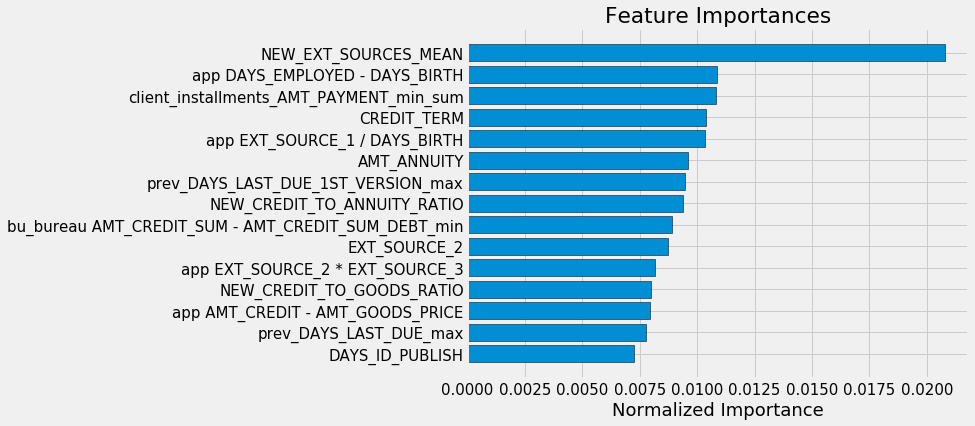

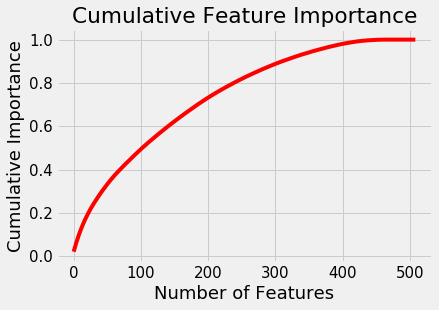

361 features required for 0.95 of cumulative importance


In [463]:
fi_sorted = plot_feature_importances(fi,0.95)

In [464]:
# Find the features with zero importance
zero_features = list(fi[fi['importance'] == 0.0]['feature'])
print('There are %d features with 0.0 importance' % len(zero_features))
fi.tail()

There are 49 features with 0.0 importance


,feature,importance
504,cred_card missing_mean,11.5
505,cred_card missing_max,0.5
506,cred_card SK_DPD_DEF - MONTHS_BALANCE_sum,1.5
507,cred_card SK_DPD - MONTHS_BALANCE_sum,1.5
508,cred_card missing_sum,10.0


In [470]:
train = train.drop(columns=zero_features)
test = test.drop(columns=zero_features)
print('Training Shape: ', train.shape)
print('Testing Shape: ', test.shape)

Training Shape:  (307511, 462)
Testing Shape:  (48744, 461)


In [102]:
submission1, fi1, metrics1 = model(train_col, test_col, n_folds = 5)
print('Baseline metrics')
print(metrics1)

Training Data Shape:  (307511, 327)
Testing Data Shape:  (48744, 327)
Training until validation scores don't improve for 100 rounds.
[200]	valid's auc: 0.786213	train's auc: 0.836108
[400]	valid's auc: 0.788532	train's auc: 0.874432
[600]	valid's auc: 0.788399	train's auc: 0.902813
Early stopping, best iteration is:
[523]	valid's auc: 0.788788	train's auc: 0.892424
Training until validation scores don't improve for 100 rounds.
[200]	valid's auc: 0.790888	train's auc: 0.83561
[400]	valid's auc: 0.793279	train's auc: 0.874244
Early stopping, best iteration is:
[438]	valid's auc: 0.793552	train's auc: 0.880273
Training until validation scores don't improve for 100 rounds.
[200]	valid's auc: 0.782208	train's auc: 0.836904
[400]	valid's auc: 0.784607	train's auc: 0.874952
[600]	valid's auc: 0.785084	train's auc: 0.903247
Early stopping, best iteration is:
[525]	valid's auc: 0.785247	train's auc: 0.89332
Training until validation scores don't improve for 100 rounds.
[200]	valid's auc: 0.7894

In [97]:
# Find the features with zero importance
zero_features = list(fi1[fi1['importance'] == 0.0]['feature'])
print('There are %d features with 0.0 importance' % len(zero_features))
fi1.tail()

There are 0 features with 0.0 importance


,feature,importance
301,prev_WEEKDAY_APPR_PROCESS_START_SUNDAY_mean,17.8
302,client_cash_SK_DPD_max_min,14.4
303,client_cash_NAME_CONTRACT_STATUS_Active_mean_min,20.6
304,prev_prev DAYS_TERMINATION less -500_mean,14.4
305,client_bu_blc_STATUS_0_sum_median,16.8


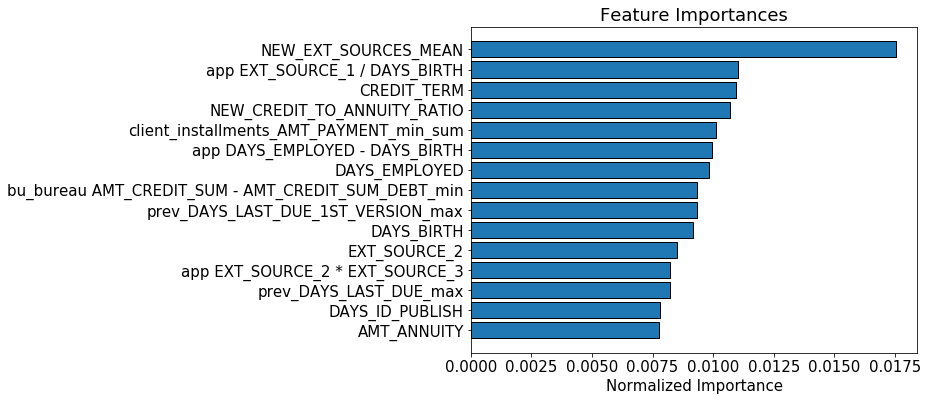

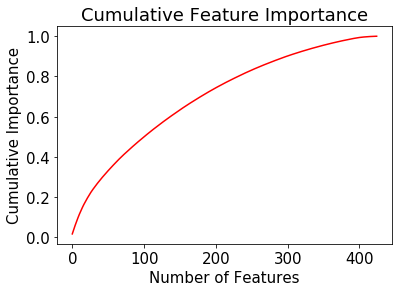

346 features required for 0.95 of cumulative importance


In [57]:
fi_sorted = plot_feature_importances(fi1,0.95)

Let's further reduce the feature size by limit to 95% cumulative feature importance.

In [60]:
# Threshold for cumulative importance
threshold = 0.95

# Extract the features to keep
features_to_keep = list(fi_sorted[fi_sorted['cumulative_importance'] < threshold]['feature'])

# Create new datasets with smaller features
train_small = train_col[features_to_keep]
test_small = test_col[features_to_keep]

In [61]:
train_small['TARGET'] = train_target
train_small['SK_ID_CURR'] = train_id_curr
test_small['SK_ID_CURR'] = test_id_curr

In [62]:
submission2, fi2, metrics2 = model(train_small, test_small)
print('Baseline metrics')
print(metrics2)

Training Data Shape:  (307511, 345)
Testing Data Shape:  (48744, 345)
Training until validation scores don't improve for 100 rounds.
[200]	valid's auc: 0.786717	train's auc: 0.836282
[400]	valid's auc: 0.788608	train's auc: 0.874879
Early stopping, best iteration is:
[415]	valid's auc: 0.788788	train's auc: 0.87719
Training until validation scores don't improve for 100 rounds.
[200]	valid's auc: 0.791636	train's auc: 0.835793
[400]	valid's auc: 0.794264	train's auc: 0.874482
[600]	valid's auc: 0.794265	train's auc: 0.903425
Early stopping, best iteration is:
[528]	valid's auc: 0.794677	train's auc: 0.893981
Training until validation scores don't improve for 100 rounds.
[200]	valid's auc: 0.783007	train's auc: 0.837092
[400]	valid's auc: 0.785807	train's auc: 0.875477
Early stopping, best iteration is:
[384]	valid's auc: 0.785864	train's auc: 0.872876
Training until validation scores don't improve for 100 rounds.
[200]	valid's auc: 0.788905	train's auc: 0.836535
[400]	valid's auc: 0.790

In [64]:
train_small.to_csv('./train_347_790696')
test_small.to_csv('./test_346_790696')

In [65]:
train = train_small
test = test_small

In [107]:
print('Training Shape: ', train.shape)
print('Testing Shape: ', test.shape)

Training Shape:  (307511, 347)
Testing Shape:  (48744, 346)


## Model tuning

### Case 2

In [ ]:
# model = lgb.LGBMClassifier(n_estimators=10000, 
#                objective = 'binary', 
#                boosting_type='gbdt',
#                class_weight = 'balanced', 
#                learning_rate = 0.02, 
#                colsample_bytree = 0.9497036,
#                subsample = 0.8715623,
#                subsample_freq = 1,
#                max_depth = 8,
#                reg_alpha = 0.041545473,
#                reg_lambda = 0.0735294,
#                min_split_gain = 0.0222415,
#                min_child_weight = 60, # 39.3259775,
#                num_leaves = 20,
#                n_jobs = -1, 
#                random_state = 50)

In [108]:
submission2, fi2, metrics2 = model(train, test)
print('Baseline metrics')
print(metrics2)

Training Data Shape:  (307511, 345)
Testing Data Shape:  (48744, 345)
Training until validation scores don't improve for 200 rounds.
[200]	valid's auc: 0.773212	train's auc: 0.790603
[400]	valid's auc: 0.78398	train's auc: 0.810805
[600]	valid's auc: 0.788035	train's auc: 0.824664
[800]	valid's auc: 0.789932	train's auc: 0.835956
[1000]	valid's auc: 0.790819	train's auc: 0.846099
[1200]	valid's auc: 0.791263	train's auc: 0.855229
[1400]	valid's auc: 0.791509	train's auc: 0.863827
[1600]	valid's auc: 0.791583	train's auc: 0.87187
Early stopping, best iteration is:
[1479]	valid's auc: 0.791671	train's auc: 0.86705
Training until validation scores don't improve for 200 rounds.
[200]	valid's auc: 0.776425	train's auc: 0.789751
[400]	valid's auc: 0.787609	train's auc: 0.809798
[600]	valid's auc: 0.791837	train's auc: 0.823831
[800]	valid's auc: 0.793398	train's auc: 0.835166
[1000]	valid's auc: 0.794367	train's auc: 0.845455
[1200]	valid's auc: 0.795042	train's auc: 0.854834
[1400]	valid's 

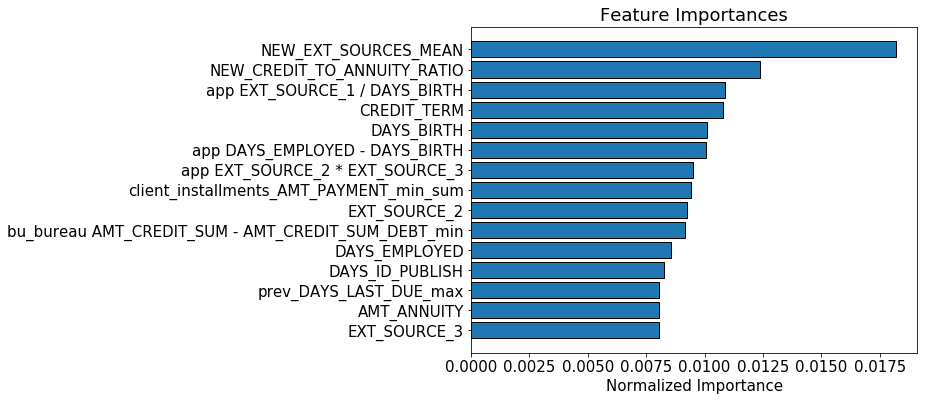

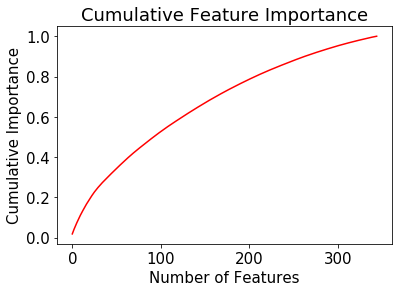

300 features required for 0.95 of cumulative importance


In [110]:
fi_sorted = plot_feature_importances(fi2,0.95)

In [112]:
submission2.to_csv('./submission2.csv', index = False)

### Case 3

In [ ]:
#         model = lgb.LGBMClassifier(n_estimators=10000, 
#                                    objective = 'binary', 
#                                    boosting_type='gbdt',
#                                    class_weight = 'balanced', 
#                                    learning_rate = 0.02, 
#                                    reg_alpha = 0.1, 
#                                    reg_lambda = 0.1,
#                                    n_jobs = -1, 
#                                    random_state = 50)

In [ ]:
submission3, fi3, metrics3 = model(train, test)
print('Baseline metrics')
print(metrics3)

Training Data Shape:  (307511, 345)
Testing Data Shape:  (48744, 345)
Training until validation scores don't improve for 200 rounds.
[200]	valid's auc: 0.775941	train's auc: 0.801477
[400]	valid's auc: 0.785932	train's auc: 0.827195
[600]	valid's auc: 0.788549	train's auc: 0.845883
[800]	valid's auc: 0.78931	train's auc: 0.860981
[1000]	valid's auc: 0.78921	train's auc: 0.874033
Early stopping, best iteration is:
[857]	valid's auc: 0.789381	train's auc: 0.864949
Training until validation scores don't improve for 200 rounds.
[200]	valid's auc: 0.778864	train's auc: 0.800674
[400]	valid's auc: 0.788954	train's auc: 0.826399
[600]	valid's auc: 0.79145	train's auc: 0.845463
[800]	valid's auc: 0.792317	train's auc: 0.860955
[1000]	valid's auc: 0.792527	train's auc: 0.87445
[1200]	valid's auc: 0.7926	train's auc: 0.88619
[1400]	valid's auc: 0.792393	train's auc: 0.896922
Early stopping, best iteration is:
[1273]	valid's auc: 0.792718	train's auc: 0.890366
Training until validation scores don

In [ ]:
fi_sorted = plot_feature_importances(fi3,0.95)

### Case 4

In [ ]:
# model = lgb.LGBMClassifier(n_estimators=10000, 
#                objective = 'binary', 
#                boosting_type='gbdt',
#                class_weight = 'balanced', 
#                learning_rate = 0.02, 
#                colsample_bytree = 0.9497036,
#                subsample = 0.8715623,
#                subsample_freq = 1,
#                max_depth = 8,
#                reg_alpha = 0.041545473,
#                reg_lambda = 0.0735294,
#                min_split_gain = 0.0222415,
#                min_child_weight = 60, # 39.3259775,
#                num_leaves = 20,
#                n_jobs = -1, 
#                random_state = 50)

In [7]:
train_small = pd.read_csv('./train_334_7889.csv')
test_small = pd.read_csv('./test_333_7889.csv')

In [8]:
submission4, fi4, metrics4 = model(train_small, test_small)
print('Baseline metrics')
print(metrics4)

Training Data Shape:  (307511, 333)
Testing Data Shape:  (48744, 333)
Training until validation scores don't improve for 200 rounds.
[200]	valid's auc: 0.769908	train's auc: 0.787604
[400]	valid's auc: 0.781303	train's auc: 0.808213
[600]	valid's auc: 0.785619	train's auc: 0.821692
[800]	valid's auc: 0.7877	train's auc: 0.832854
[1000]	valid's auc: 0.788476	train's auc: 0.842688
[1200]	valid's auc: 0.789082	train's auc: 0.851802
[1400]	valid's auc: 0.789391	train's auc: 0.860277
[1600]	valid's auc: 0.78987	train's auc: 0.868168
[1800]	valid's auc: 0.79	train's auc: 0.875538
[2000]	valid's auc: 0.790111	train's auc: 0.882418
[2200]	valid's auc: 0.789937	train's auc: 0.888925
Early stopping, best iteration is:
[2000]	valid's auc: 0.790111	train's auc: 0.882418
Training until validation scores don't improve for 200 rounds.
[200]	valid's auc: 0.774318	train's auc: 0.786374
[400]	valid's auc: 0.786253	train's auc: 0.806881
[600]	valid's auc: 0.79064	train's auc: 0.820691
[800]	valid's auc: 

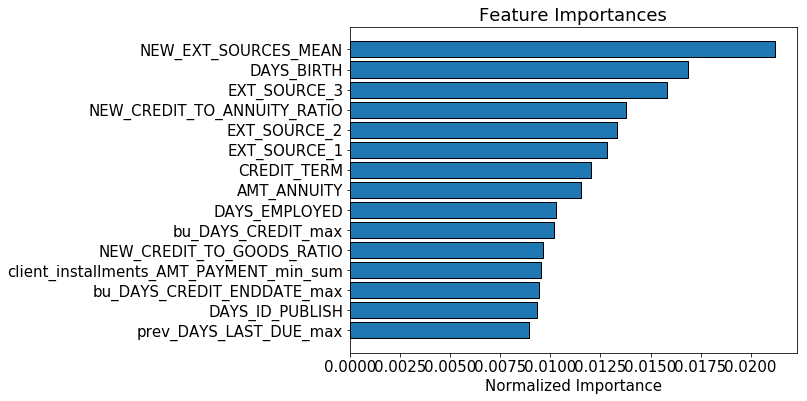

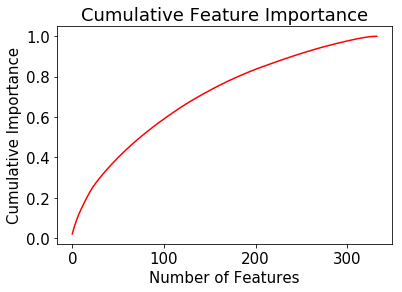

278 features required for 0.95 of cumulative importance


In [9]:
fi_sorted = plot_feature_importances(fi4,0.95)

In [19]:
submission4.to_csv('./submission4.csv', index = False)

### Case 5

In [ ]:
# model = lgb.LGBMClassifier(n_estimators=10000, 
#                objective = 'binary', 
#                boosting_type='gbdt',
#                class_weight = 'balanced', 
#                learning_rate = 0.02, 
#                colsample_bytree = 0.9497036,
#                subsample = 0.8715623,
#                subsample_freq = 1,
#                max_depth = 8,
#                reg_alpha = 0.15,
#                reg_lambda = 0.15,
#                min_split_gain = 0.0222415,
#                min_child_weight = 60, # 39.3259775,
#                num_leaves = 20,
#                n_jobs = -1, 
#                random_state = 50)

In [12]:
submission5, fi5, metrics5 = model(train_small, test_small)
print('Baseline metrics')
print(metrics5)

Training Data Shape:  (307511, 333)
Testing Data Shape:  (48744, 333)
Training until validation scores don't improve for 200 rounds.
[200]	valid's auc: 0.770166	train's auc: 0.787569
[400]	valid's auc: 0.781326	train's auc: 0.808025
[600]	valid's auc: 0.78572	train's auc: 0.821551
[800]	valid's auc: 0.787799	train's auc: 0.832614
[1000]	valid's auc: 0.78875	train's auc: 0.842487
[1200]	valid's auc: 0.789293	train's auc: 0.851583
[1400]	valid's auc: 0.789736	train's auc: 0.859961
[1600]	valid's auc: 0.790201	train's auc: 0.867905
[1800]	valid's auc: 0.790226	train's auc: 0.875325
Early stopping, best iteration is:
[1666]	valid's auc: 0.790342	train's auc: 0.870469
Training until validation scores don't improve for 200 rounds.
[200]	valid's auc: 0.774115	train's auc: 0.786298
[400]	valid's auc: 0.786187	train's auc: 0.806774
[600]	valid's auc: 0.790723	train's auc: 0.82066
[800]	valid's auc: 0.792552	train's auc: 0.831906
[1000]	valid's auc: 0.793651	train's auc: 0.841949
[1200]	valid's 

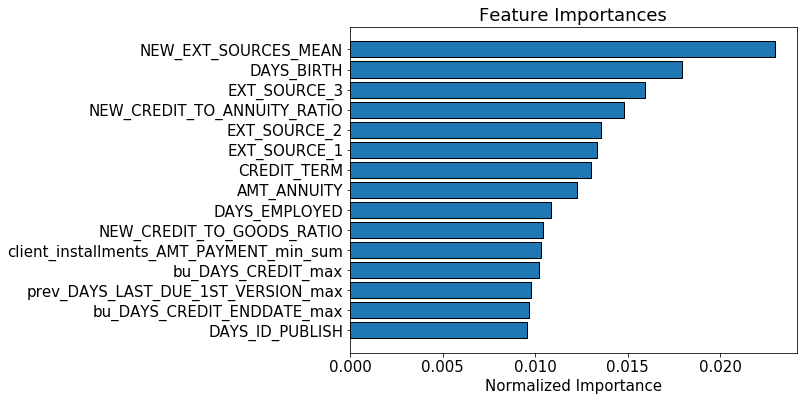

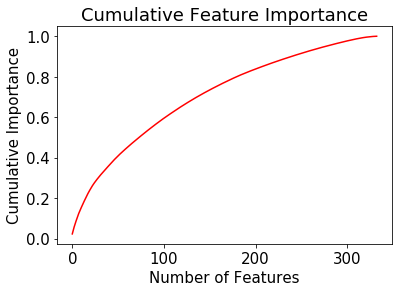

278 features required for 0.95 of cumulative importance


In [13]:
fi_sorted = plot_feature_importances(fi5,0.95)

In [14]:
submission5.to_csv('./submission5.csv', index = False)

### Case 6

In [ ]:
# model = lgb.LGBMClassifier(n_estimators=10000, 
#                objective = 'binary', 
#                boosting_type='gbdt',
#                class_weight = 'balanced', 
#                learning_rate = 0.02, 
#                colsample_bytree = 0.9497036,
#                subsample = 0.8715623,
#                subsample_freq = 1,
#                max_depth = 6,
#                reg_alpha = 0.15,
#                reg_lambda = 0.15,
#                min_split_gain = 0.0222415,
#                min_child_weight = 60, # 39.3259775,
#                num_leaves = 20,
#                n_jobs = -1, 
#                random_state = 50)

In [16]:
submission6, fi6, metrics6 = model1(train_small, test_small)
print('Baseline metrics')
print(metrics6)

Training Data Shape:  (307511, 333)
Testing Data Shape:  (48744, 333)
Training until validation scores don't improve for 200 rounds.
[200]	valid's auc: 0.769864	train's auc: 0.787239
[400]	valid's auc: 0.780719	train's auc: 0.807287
[600]	valid's auc: 0.785111	train's auc: 0.82045
[800]	valid's auc: 0.787412	train's auc: 0.831166
[1000]	valid's auc: 0.788613	train's auc: 0.840761
[1200]	valid's auc: 0.789244	train's auc: 0.849557
[1400]	valid's auc: 0.789602	train's auc: 0.857664
[1600]	valid's auc: 0.790024	train's auc: 0.865322
[1800]	valid's auc: 0.79021	train's auc: 0.872348
Early stopping, best iteration is:
[1793]	valid's auc: 0.790231	train's auc: 0.87211
Training until validation scores don't improve for 200 rounds.
[200]	valid's auc: 0.773681	train's auc: 0.785785
[400]	valid's auc: 0.785035	train's auc: 0.805966
[600]	valid's auc: 0.789873	train's auc: 0.819484
[800]	valid's auc: 0.792153	train's auc: 0.830465
[1000]	valid's auc: 0.793589	train's auc: 0.840034
[1200]	valid's 

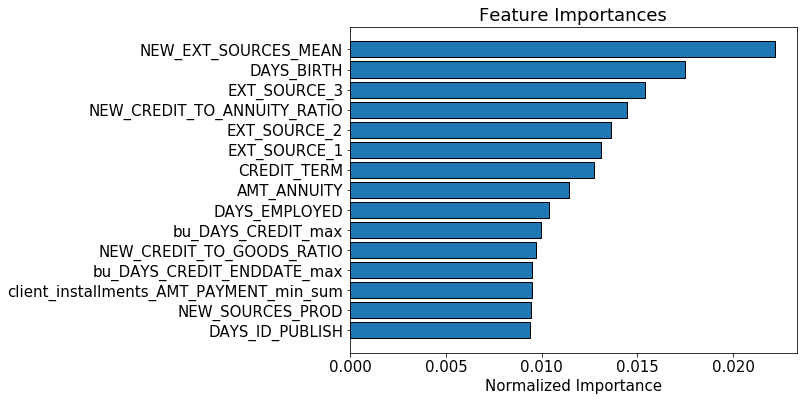

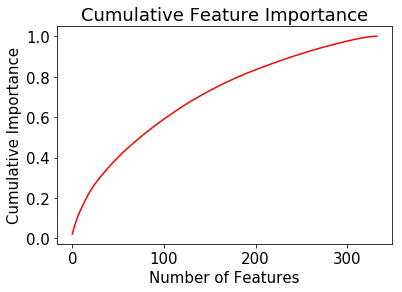

278 features required for 0.95 of cumulative importance


In [17]:
fi_sorted = plot_feature_importances(fi6,0.95)

In [20]:
submission6.to_csv('./submission6.csv', index = False)

### Case 7

In [ ]:
# model = lgb.LGBMClassifier(n_estimators=10000, 
#                objective = 'binary', 
#                boosting_type='gbdt',
#                class_weight = 'balanced', 
#                learning_rate = 0.02, 
#                colsample_bytree = 0.9497036,
#                subsample = 0.8715623,
#                subsample_freq = 1,
#                max_depth = 6,
#                reg_alpha = 0.041545473,
#                reg_lambda = 0.0735294,
#                min_split_gain = 0.0222415,
#                min_child_weight = 60, # 39.3259775,
#                num_leaves = 20,
#                n_jobs = -1, 
#                random_state = 50)

In [ ]:
submission7, fi7, metrics7 = model1(train_small, test_small)
print('Baseline metrics')
print(metrics7)

Training Data Shape:  (307511, 333)
Testing Data Shape:  (48744, 333)
Training until validation scores don't improve for 200 rounds.
[200]	valid's auc: 0.769643	train's auc: 0.787084
[400]	valid's auc: 0.780545	train's auc: 0.807314
[600]	valid's auc: 0.784876	train's auc: 0.820487
[800]	valid's auc: 0.787357	train's auc: 0.831282
[1000]	valid's auc: 0.788369	train's auc: 0.84067
[1200]	valid's auc: 0.788975	train's auc: 0.849455
[1400]	valid's auc: 0.789323	train's auc: 0.857585
[1600]	valid's auc: 0.789742	train's auc: 0.865167
[1800]	valid's auc: 0.789803	train's auc: 0.872263
Early stopping, best iteration is:
[1781]	valid's auc: 0.789857	train's auc: 0.871614
Training until validation scores don't improve for 200 rounds.
[200]	valid's auc: 0.773437	train's auc: 0.7857
[400]	valid's auc: 0.784921	train's auc: 0.805919
[600]	valid's auc: 0.789616	train's auc: 0.819326
[800]	valid's auc: 0.791973	train's auc: 0.830223
[1000]	valid's auc: 0.793271	train's auc: 0.839798
[1200]	valid's 

In [ ]:
fi_sorted = plot_feature_importances(fi7,0.95)

In [ ]:
submission7.to_csv('./submission7.csv', index = False)

### Case 8

In [ ]:
# model = lgb.LGBMClassifier(n_estimators=10000, 
#                objective = 'binary', 
#                boosting_type='gbdt',
#                class_weight = 'balanced', 
#                learning_rate = 0.02, 
#                colsample_bytree = 0.9497036,
#                subsample = 0.8715623,
#                subsample_freq = 1,
#                reg_alpha = 0.005,
#                reg_lambda = 0.005,
#                min_split_gain = 0.0222415,
#                min_child_weight = 60, # 39.3259775,
#                num_leaves = 20,
#                n_jobs = -1, 
#                random_state = 50)

In [ ]:
submission8, fi8, metrics8 = model(train_small, test_small)
print('Baseline metrics')
print(metrics8)

In [ ]:
fi_sorted = plot_feature_importances(fi8,0.95)

In [ ]:
submission8.to_csv('./submission8.csv', index = False)

## Model implementation
### Light GBM

#### Polynomial features

In [ ]:
submission1, fi1, metrics1 = model(train_poly, test_poly)
print('Baseline metrics')
print(metrics1)

In [ ]:
fi_sorted1 = plot_feature_importances(fi1)

From above, we can see the polynomial features make almost no improvements.

#### Domain knowledge features

In [ ]:
submission2, fi2, metrics2 = model(train_domain, test_domain)
print('Baseline metrics')
print(metrics2)

In [ ]:
fi_sorted2 = plot_feature_importances(fi2)